<a href="https://colab.research.google.com/github/Vamsi-Malineni/Research-work/blob/master/raissi_research_nsfnet_ada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import scipy.io
import time
import pandas as pd
import math
import pickle
import copy

In [ ]:
# set random seed
np.random.seed(1234)
tf.set_random_seed(1234)


class pinn:
    # Initialize the class
    def __init__(self, data_idx, data_t0, data_sup_b_train, layers, N_train, batch_size):
        
        self.lowb = data_idx.min(0)  # minimal number in each column
        self.upb = data_idx.max(0)

        self.data_t0 = data_t0
        self.data_sup_b_train = data_sup_b_train
        self.data_idx = data_idx
        self.N_train = N_train
        self.batch_size=batch_size

        self.layers = layers

        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)
        self.learning_rate = tf.placeholder(tf.float32, shape=[])

        # self.encoder_weights_1=self.xavier_init([3,layers[1]])
        # self.encoder_biases_1=self.xavier_init([1,layers[1]])

        # self.encoder_weights_2=self.xavier_init([3,layers[1]])
        # self.encoder_biases_2=self.xavier_init([1,layers[1]])

        # Adaptive re-weighting constants
        self.beta=0.9
        self.adaptive_constant_bcs_val=np.array(1.0)  # arw for boundary conditions
        self.adaptive_constant_ics_val=np.array(1.0)  # arw for initial conditions


        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        # initial condition placeholders
        self.x_ini_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_ini_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_ini_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u_ini_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.v_ini_tf = tf.placeholder(tf.float32, shape=[None, 1])

        # boundary condition placeholders
        self.x_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc1_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc2_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc3_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc4_tf = tf.placeholder(tf.float32, shape=(None, 2))

        # domain residual placeholders
        self.x_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, 1])

        # defining a placeholder for adaptive constant
        self.adaptive_constant_bcs_tf=tf.placeholder(tf.float32,shape=self.adaptive_constant_bcs_val.shape)
        self.adaptive_constant_ics_tf=tf.placeholder(tf.float32,shape=self.adaptive_constant_ics_val.shape)
        
#================================================================================================================#
        # Evaluating predictions

        # Initial value predictions
        self.u_ini_pred, self.v_ini_pred, self.p_ini_pred = self.net_NS(self.x_ini_tf, self.y_ini_tf, self.t_ini_tf)
        
        # Boundary value predictions

        self.u_bc1_pred, self.v_bc1_pred,_ = self.net_NS(self.x_bc1_tf, self.y_bc1_tf,self.t_bc1_tf)
        self.u_bc2_pred, self.v_bc2_pred,_ = self.net_NS(self.x_bc2_tf, self.y_bc2_tf,self.t_bc2_tf)
        self.u_bc3_pred, self.v_bc3_pred,_ = self.net_NS(self.x_bc3_tf, self.y_bc3_tf,self.t_bc3_tf)
        self.u_bc4_pred, self.v_bc4_pred,_ = self.net_NS(self.x_bc4_tf, self.y_bc4_tf,self.t_bc4_tf)
        
        self.U_bc1_pred = tf.concat([self.u_bc1_pred, self.v_bc1_pred], axis=1)
        self.U_bc2_pred = tf.concat([self.u_bc2_pred, self.v_bc2_pred], axis=1)
        self.U_bc3_pred = tf.concat([self.u_bc3_pred, self.v_bc3_pred], axis=1)
        self.U_bc4_pred = tf.concat([self.u_bc4_pred, self.v_bc4_pred], axis=1)

        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred, self.f_e_pred = \
            self.net_f_NS(self.x_tf, self.y_tf, self.t_tf)

        # Defining loss functions for boundary conditions and initial conditions

        self.loss_bcs=self.adaptive_constant_bcs_tf*(tf.reduce_mean(tf.square(self.U_bc1_pred - self.U_bc1_tf)+tf.square(self.U_bc2_pred - self.U_bc2_tf)+tf.square(self.U_bc3_pred - self.U_bc3_tf)+tf.square(self.U_bc4_pred - self.U_bc4_tf)))

        self.loss_ics=self.adaptive_constant_ics_tf*(tf.reduce_mean(tf.square(self.u_ini_tf - self.u_ini_pred)) + tf.reduce_mean(tf.square(self.v_ini_tf - self.v_ini_pred)))
        
        # Defining loss function for residual in the domain 
        
        self.loss_res= tf.reduce_mean(tf.square(self.f_u_pred)) + tf.reduce_mean(tf.square(self.f_v_pred)) + tf.reduce_mean(tf.square(self.f_e_pred))


        # set loss function
        self.loss =self.loss_res + self.loss_bcs + self.loss_ics

        # Deifining optimizer with learning rate schedule
        self.global_step=tf.Variable(0,trainable=False)
        starter_learning_rate=1e-3
        self.learning_rate=tf.train.exponential_decay(starter_learning_rate,self.global_step,1000,0.9,staircase=False)

        # set optimizer
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                method='L-BFGS-B',
                                                                options={'maxiter': 50000,
                                                                         'maxfun': 50000,
                                                                         'maxcor': 50,
                                                                         'maxls': 50,
                                                                         'ftol': 1.0 * np.finfo(float).eps})

        self.optimizer_Adam = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss,global_step=self.global_step)

        # Collecting gradients of the individual loss terms wrt the parameters of the network
        self.grad_res=[]
        self.grad_bcs=[]
        self.grad_ics=[]
        
        for i in range(len(self.layers)-1):
          self.grad_res.append(tf.gradients(self.loss_res,self.weights[i])[0])
          self.grad_bcs.append(tf.gradients(self.loss_bcs,self.weights[i])[0])
          self.grad_ics.append(tf.gradients(self.loss_ics,self.weights[i])[0])
        
        # Collecting the adaptive constants for initial and boundary conditions
        self.adaptive_constant_bcs_list=[]
        self.adaptive_constant_ics_list=[]

        self.adaptive_constant_bcs_log=[]
        self.adaptive_constant_ics_log=[]

        for i in range(len(self.layers)-1):
          self.adaptive_constant_bcs_list.append(
              tf.reduce_max(tf.abs(self.grad_res[i])) / tf.reduce_mean(tf.abs(self.grad_bcs[i]))
          )
          self.adaptive_constant_ics_list.append(
              tf.reduce_max(tf.abs(self.grad_res[i])) / tf.reduce_mean(tf.abs(self.grad_ics[i]))
          )
        
        self.adaptive_constant_bcs=tf.reduce_max(tf.stack(self.adaptive_constant_bcs_list))
        self.adpative_constant_ics=tf.reduce_max(tf.stack(self.adaptive_constant_ics_list))
        
        # Initializing Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

        # Creating batches for domain data
    def summon_batch_domain(self,batch_size,start):
      ''' 
      This function returns a list containing randomnly picked points from the domain
      '''
      data=copy.deepcopy(self.data_idx)
      points=[]

      for i in range(start,len(data),batch_size): # Something is wrong here

        points.append(data[i:i+batch_size,0:3])
        break # breaks after the first iteration

      return points

    def domain_batches(self,batch_size):
      '''
      This function is used to call the domain data points in batches
      This function returns an array of arrays of shape(438,1) each of the 438 arrays
      will have batch size number of points
      '''
      batches=[]
      num_batches=math.ceil(self.N_train/batch_size)

      for i in range(0,len(data_idx),batch_size):
        batches.append(self.summon_batch_domain(batch_size,i))

      return np.asarray(batches,dtype=object) 

# Creating batches for initial conditions
    def summon_batch_ic(self,batch_size,start):

      data=copy.deepcopy(data_t0)
      points=[]

      for i in range(start,len(data),batch_size): 

        points.append(data[i:i+batch_size])
        break # breaks after the first iteration

      return points
    def ic_batches(self,batch_size):
      batches=[]
      num_batches=math.ceil(self.data_t0.shape[0]/batch_size)

      for i in range(0,len(self.data_t0),batch_size):
        batches.append(self.summon_batch_ic(batch_size,i))

      return np.asarray(batches,dtype=object)       

# Creatng batches for boundary condition
    def summon_batch_bc(self,batch_size,bc_con,start):
      
      if bc_con==1:
        data=copy.deepcopy(data_sup_b_train[0:20000,:])
      elif bc_con==2:
        data=copy.deepcopy(data_sup_b_train[20000:40000,:])
      elif bc_con==3:
        data=copy.deepcopy(data_sup_b_train[40000:60000,:])
      elif bc_con==4:
        data=copy.deepcopy(data_sup_b_train[60000:80000,:])

      points=[]

      for i in range(start,len(data),batch_size): 

        points.append(data[i:i+batch_size])
        break # breaks after the first iteration

      return points	
    
    def bc_batches(self,batch_size,bc_con):

      batches=[]
      
      for i in range(0,int(len(data_sup_b_train)/4),batch_size):
        batches.append(self.summon_batch_bc(batch_size,bc_con,i))

      return np.asarray(batches,dtype=object) 

# initialize the weights and biases
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

# xavier used to initialize the weight
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

# saving the weights and biases for transfer learning
    def save_parameters(self,fileDr):
      weights=self.sess.run(self.weights)
      biases= self.sess.run(self.biases)

      with open(fileDr,'wb') as f:
        pickle.dump([weights,biases],f)
        print("Parameters are saved in pickle file")
        
# loading the weights and biases for transfer learning
    def load_parameters(self,fileDr,layers):
      weights=[]
      biases=[]
      num_layers=len(layers)

      with open(fileDr,'rb') as f:
        weights,biases=pickle.load(f)

        assert num_layers == (len(weights)+1)

        for num in range(0,num_layers-1):
          W=tf.Variable(weights[num])
          b=tf.Variable(biases[num])
          weights.append(W)
          biases.append(b)
        print("Parameters are loaded succesffuly")
      return weights,biases

# generate the neural network
    def neural_net(self, X):
        num_layers = len(self.weights) + 1

        H = 2.0 * (X - self.lowb) / (self.upb - self.lowb) - 1.0
        for l in range(0, num_layers - 2):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = self.weights[-1]
        b = self.biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    # def neural_net(self, X):
    #     num_layers = len(self.layers)
    #     H = X

    #     # H = 2.0 * (X - self.lowb) / (self.upb - self.lowb) - 1.0
    #     encoder_1= tf.tanh(tf.add(tf.matmul(H,self.encoder_weights_1),self.encoder_biases_1))
    #     encoder_2= tf.tanh(tf.add(tf.matmul(H,self.encoder_weights_2),self.encoder_biases_2))
        
    #     for l in range(0, num_layers - 1):
    #         W = self.weights[l]
    #         b = self.biases[l]
    #         print("h shape:",H.shape)
    #         print("w shape:",W.shape)
    #         print(tf.matmul(H, W).shape)
    #         H = tf.math.multiply(tf.tanh(tf.add(tf.matmul(H, W), b)),encoder_1)+ tf.math.multiply(1 - tf.tanh(tf.add(tf.matmul(H, W), b)),encoder_2)
    #     W = self.weights[-1]
    #     b = self.biases[-1]
    #     H = tf.add(tf.matmul(H, W), b)
    #     return H

    # supervised data driven
    def net_NS(self, x, y, t):

        
        psi_p = self.neural_net(tf.concat([x, y, t], 1))
        psi = psi_p[:, 0:1]
        p   = psi_p[:, 1:2]
        
        u=tf.gradients(psi,y)[0]
        v=(-1) * tf.gradients(psi,x)[0]

        return u, v, p

    # unsupervised NS residual
    def net_f_NS(self, x, y, t):

        psi_p = self.neural_net(tf.concat([x, y, t], 1))
        psi = psi_p[:, 0:1]
        p   = psi_p[:, 1:2]
        
        u=tf.gradients(psi,y)[0]
        v=(-1) * tf.gradients(psi,x)[0]
        
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]

        v_t = tf.gradients(v, t)[0]
        v_x = tf.gradients(v, x)[0]
        v_y = tf.gradients(v, y)[0]
        v_xx = tf.gradients(v_x, x)[0]
        v_yy = tf.gradients(v_y, y)[0]

        p_x = tf.gradients(p, x)[0]
        p_y = tf.gradients(p, y)[0]

        f_u = u_t + (u * u_x + v * u_y) + p_x - 0.01 * (u_xx + u_yy)
        f_v = v_t + (u * v_x + v * v_y) + p_y - 0.01 * (v_xx + v_yy)
        f_e = 0.0

        return u, v, p, f_u, f_v, f_e

    def callback(self, loss):
        print('Loss: %.3e' % loss)

# tf_dict is used to connect model variable and data

    def Adam_train(self, epochs=5000):

        start_time = time.time()
        
        for epoch in range(epochs):
          # number of batch will vary for domain, initial and boundary conditions.
            dom_bat_no=np.random.randint(1,(math.ceil(self.N_train/self.batch_size)))
            init_bat_no=np.random.randint(1,(math.ceil(self.data_t0.shape[0]/self.batch_size)))
            bound_bat_no=np.random.randint(1,(math.ceil((self.data_sup_b_train.shape[0]/4)/self.batch_size)))
            
            # call batches here 
            d_batch = self.domain_batches (self.batch_size)[dom_bat_no][0]
            i_batch = self.ic_batches     (self.batch_size)[init_bat_no][0]
            b_batch1 = self.bc_batches     (self.batch_size,1)[bound_bat_no][0]
            b_batch2 = self.bc_batches     (self.batch_size,2)[bound_bat_no][0]
            b_batch3 = self.bc_batches     (self.batch_size,3)[bound_bat_no][0]
            b_batch4 = self.bc_batches     (self.batch_size,4)[bound_bat_no][0]
            
            tf_dict = {
                  self.x_ini_tf: i_batch[:,0:1] , 
                  self.y_ini_tf: i_batch[:,1:2] ,
                  self.t_ini_tf: i_batch[:,2:3] , 
                  self.u_ini_tf: i_batch[:,3:4],
                  self.v_ini_tf: i_batch[:,4:5] , 

                  self.x_bc1_tf: b_batch1[:,0:1] ,
                  self.y_bc1_tf: b_batch1[:,1:2] , 
                  self.t_bc1_tf: b_batch1[:,2:3] ,
                  self.U_bc1_tf: b_batch1[:,3:5] ,

                  self.x_bc2_tf: b_batch2[:,0:1] ,
                  self.y_bc2_tf: b_batch2[:,1:2] , 
                  self.t_bc2_tf: b_batch2[:,2:3] ,
                  self.U_bc2_tf: b_batch1[:,3:5] ,
                  
                  self.x_bc3_tf: b_batch3[:,0:1] ,
                  self.y_bc3_tf: b_batch3[:,1:2] , 
                  self.t_bc3_tf: b_batch3[:,2:3] ,
                  self.U_bc3_tf: b_batch1[:,3:5] ,
                  
                  self.x_bc4_tf: b_batch4[:,0:1] ,
                  self.y_bc4_tf: b_batch4[:,1:2] , 
                  self.t_bc4_tf: b_batch4[:,2:3] ,
                  self.U_bc4_tf: b_batch1[:,3:5] ,
                  
                  self.x_tf: d_batch[:,0:1] , 
                  self.y_tf:d_batch[:,1:2] , 
                  self.t_tf:d_batch[:,2:3] ,

                  self.adaptive_constant_bcs_tf: self.adaptive_constant_bcs_val,
                  self.adaptive_constant_ics_tf: self.adaptive_constant_ics_val}

            # add the tf dict here 
            self.sess.run(self.train_op_Adam, tf_dict)

            # Print
            if epoch % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                adaptive_constant_bcs_val=self.sess.run(self.adaptive_constant_bcs,tf_dict)
                adaptive_constant_ics_val=self.sess.run(self.adpative_constant_ics,tf_dict)

                self.adaptive_constant_bcs_val=adaptive_constant_bcs_val* (1.0-self.beta)+self.beta*self.adaptive_constant_bcs_val
                self.adaptive_constant_ics_val=adaptive_constant_ics_val* (1.0-self.beta)+self.beta*self.adaptive_constant_ics_val

                print('epoch: %d, Loss: %.3e, Time: %.2f' %
                      (epoch, loss_value, elapsed))
                print("constant_bcs_val: {:.3f}".format(self.adaptive_constant_bcs_val))
                print("constant_ics_val: {:.3f}".format(self.adaptive_constant_ics_val))
                start_time = time.time()

# two step train BFGS used to finetune the result
    def BFGS_train(self):

        tf_dict = {self.x_ini_tf: self.x0, self.y_ini_tf: self.y0,
                   self.t_ini_tf: self.t0, self.u_ini_tf: self.u0,
                   self.v_ini_tf: self.v0, self.x_boundary_tf: self.xb,
                   self.y_boundary_tf: self.yb, self.t_boundary_tf: self.tb,
                   self.u_boundary_tf: self.ub, self.v_boundary_tf: self.vb,
                   self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t}

        self.optimizer.minimize(self.sess,
                                feed_dict=tf_dict,
                                fetches=[self.loss],
                                loss_callback=self.callback)


    def predict(self, x_star, y_star, t_star):

        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}

        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)

        return u_star, v_star, p_star

In [ ]:

if __name__ == "__main__":

    N_train = 14000
    batch_size= 32

    layers = [3, 50,50,50, 2]

    # Load Data
    #path=r"C:\Users\vamsi_oe20s302\Downloads\all_pressures"
    path=r"C:\Users\Vamsi\Downloads\all_pressures"
    uvel=pd.read_csv(path+r"/u_vel.csv")
    uvel=uvel.to_numpy()

    vvel=pd.read_csv(path+r"/v_vel.csv")
    vvel=vvel.to_numpy()

    press=pd.read_csv(path+r"/static_press.csv")
    press=press.to_numpy()

    xy=pd.read_csv(path+r"/xy.csv")
    xy=xy.to_numpy()

    t=pd.read_csv(path+r"/time.csv")
    t=t.to_numpy()

    N=xy.shape[0]
    T=t.shape[0]
    idx1 = np.arange(0, N*T)

    XX = np.tile(xy[:,0:1], (1,T)) # N x T
    YY = np.tile(xy[:,1:2], (1,T)) # N x T
    TT = np.tile(t, (1,N)).T # N x T

    x = XX.flatten()[:,None] # NT x 1
    y = YY.flatten()[:,None] # NT x 1
    t = TT.flatten()[:,None] # NT x 1

    u = uvel.flatten()[:,None] # NT x 1
    v = vvel.flatten()[:,None] # NT x 1
    p = press.flatten()[:,None] # NT x 1

    # need add unsupervised part
    ax=np.unique(x)
    xmin=min(ax)
    xmax=max(ax)
    ay=np.unique(y)
    ymin=min(ay)
    ymax=max(ay)

    # Concatenating all the points
    data1=np.concatenate([x ,y ,t , u , v ,p ],1)

    data2=data1[:,:][data1[:,2]<=20]
    data3=data2[:,:][data2[:,0]>=xmin]
    data4=data3[:,:][data3[:,0]<=xmax]
    data5=data4[:,:][data4[:,1]>=ymin]
    
    # Creating domain dataset size= (2000000,6)
    # It is from this dataset, we extract idx points for calculating the NS residual
    data_domain=data5[:,:][data5[:,1]<=ymax]

    # Creating initial condition dataset size=(10000,6)
    data_t0=data_domain[:,:][data_domain[:,2]==0]
    
    # Defining boundary conditions for the data
    bc1_data=data_domain[:,:][data_domain[:,1]==ymax]
    bc2_data=data_domain[:,:][data_domain[:,0]==xmin]
    bc3_data=data_domain[:,:][data_domain[:,0]==xmax]
    bc4_data=data_domain[:,:][data_domain[:,1]==ymin]

    # Creating boundary conditions dataset size=(80000,6)
    data_sup_b_train = np.concatenate([bc1_data,bc2_data,bc3_data,bc4_data], 0)
    
    # Creating random indexes for domain residual sampling points
    idx = np.random.choice(data_domain.shape[0], N_train, replace=False)
    
    # Extracting random points(x,y,t) from the domain dataset
    data_idx=data_domain[idx][:,0:3]

    # Initializing the model
    model= pinn(data_idx,data_t0,data_sup_b_train,layers,N_train,batch_size)

    model.Adam_train(50000)
#     model.Adam_train(5000)
#     model.Adam_train(50000)
#     model.Adam_train(50000)
    #model.BFGS_train()

    # Test Data
    snap = np.array([100])
    x_star = xy[:, 0:1]
    y_star = xy[:, 1:2]
    t_star = TT[:, snap]

    u_star = uvel[:, snap]
    v_star = vvel[:, snap]
    p_star = press[:, snap]

    # Prediction
    u_pred, v_pred, p_pred = model.predict(x_star, y_star, t_star)

    # Error
    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)
    error_p = np.linalg.norm(p_star - p_pred, 2) / np.linalg.norm(p_star, 2)

    print('Error u: %e' % error_u)
    print('Error v: %e' % error_v)
    print('Error p: %e' % error_p)





Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



epoch: 0, Loss: 1.383e+00, Time: 18.19
constant_bcs_val: 1.299
constant_ics_val: 1.542
epoch: 10, Loss: 4.295e-01, Time: 26.03
constant_bcs_val: 3.748
constant_ics_val: 1.906
epoch: 20, Loss: 1.003e-01, Time: 24.84
constant_bcs_val: 3.789
constant_ics_val: 2.445
epoch: 30, Loss: 3.444e-01, Time: 26.92
constant_bcs_val: 3.505
constant_ics_val: 2.324
epoch: 40, Loss: 2.266e-01, Time: 31.23
constant_bcs_val: 3.536
constant_ics_val: 2.367
epoch: 50, Loss: 4.073e-01, Time:

epoch: 720, Loss: 3.021e-01, Time: 20.34
constant_bcs_val: 1.834
constant_ics_val: 1.162
epoch: 730, Loss: 7.114e-02, Time: 20.32
constant_bcs_val: 1.750
constant_ics_val: 1.486
epoch: 740, Loss: 7.996e-03, Time: 20.45
constant_bcs_val: 1.840
constant_ics_val: 1.588
epoch: 750, Loss: 1.163e-01, Time: 20.68
constant_bcs_val: 1.778
constant_ics_val: 1.569
epoch: 760, Loss: 3.105e-01, Time: 20.42
constant_bcs_val: 1.675
constant_ics_val: 1.466
epoch: 770, Loss: 7.339e-02, Time: 19.97
constant_bcs_val: 1.601
constant_ics_val: 1.358
epoch: 780, Loss: 4.579e-02, Time: 20.00
constant_bcs_val: 1.592
constant_ics_val: 1.862
epoch: 790, Loss: 2.705e-01, Time: 19.85
constant_bcs_val: 1.478
constant_ics_val: 1.712
epoch: 800, Loss: 4.173e-02, Time: 20.02
constant_bcs_val: 1.511
constant_ics_val: 1.617
epoch: 810, Loss: 5.889e-02, Time: 19.98
constant_bcs_val: 1.527
constant_ics_val: 1.575
epoch: 820, Loss: 1.489e-01, Time: 20.28
constant_bcs_val: 1.722
constant_ics_val: 1.519
epoch: 830, Loss: 1.9

epoch: 1640, Loss: 7.297e-02, Time: 16.49
constant_bcs_val: 2.771
constant_ics_val: 1.829
epoch: 1650, Loss: 2.024e-01, Time: 16.51
constant_bcs_val: 2.532
constant_ics_val: 1.684
epoch: 1660, Loss: 1.693e-01, Time: 16.41
constant_bcs_val: 2.557
constant_ics_val: 1.606
epoch: 1670, Loss: 6.866e-02, Time: 16.34
constant_bcs_val: 2.658
constant_ics_val: 1.508
epoch: 1680, Loss: 2.791e-01, Time: 16.18
constant_bcs_val: 2.433
constant_ics_val: 1.384
epoch: 1690, Loss: 4.928e-02, Time: 16.40
constant_bcs_val: 2.324
constant_ics_val: 1.376
epoch: 1700, Loss: 5.442e-02, Time: 16.28
constant_bcs_val: 2.540
constant_ics_val: 1.305
epoch: 1710, Loss: 1.458e-01, Time: 16.35
constant_bcs_val: 2.560
constant_ics_val: 1.358
epoch: 1720, Loss: 2.131e-01, Time: 16.35
constant_bcs_val: 2.355
constant_ics_val: 1.359
epoch: 1730, Loss: 4.494e-02, Time: 16.24
constant_bcs_val: 2.162
constant_ics_val: 1.378
epoch: 1740, Loss: 2.153e-01, Time: 16.23
constant_bcs_val: 2.022
constant_ics_val: 1.323
epoch: 175

epoch: 2550, Loss: 9.796e-02, Time: 16.18
constant_bcs_val: 6.231
constant_ics_val: 3.448
epoch: 2560, Loss: 1.560e+00, Time: 16.12
constant_bcs_val: 6.146
constant_ics_val: 3.127
epoch: 2570, Loss: 2.828e-02, Time: 16.13
constant_bcs_val: 5.662
constant_ics_val: 4.721
epoch: 2580, Loss: 7.181e-02, Time: 16.10
constant_bcs_val: 5.283
constant_ics_val: 4.479
epoch: 2590, Loss: 4.737e-01, Time: 16.18
constant_bcs_val: 5.080
constant_ics_val: 4.105
epoch: 2600, Loss: 7.911e-02, Time: 16.19
constant_bcs_val: 5.363
constant_ics_val: 4.281
epoch: 2610, Loss: 9.795e-02, Time: 15.91
constant_bcs_val: 4.896
constant_ics_val: 3.988
epoch: 2620, Loss: 6.065e-01, Time: 16.22
constant_bcs_val: 4.945
constant_ics_val: 3.636
epoch: 2630, Loss: 2.746e-02, Time: 16.22
constant_bcs_val: 4.576
constant_ics_val: 3.725
epoch: 2640, Loss: 2.574e-01, Time: 16.16
constant_bcs_val: 4.239
constant_ics_val: 3.468
epoch: 2650, Loss: 1.844e-02, Time: 16.22
constant_bcs_val: 4.574
constant_ics_val: 3.764
epoch: 266

epoch: 3460, Loss: 1.980e-01, Time: 16.09
constant_bcs_val: 6.937
constant_ics_val: 4.996
epoch: 3470, Loss: 2.081e-01, Time: 16.01
constant_bcs_val: 6.986
constant_ics_val: 4.787
epoch: 3480, Loss: 1.150e-01, Time: 15.95
constant_bcs_val: 6.953
constant_ics_val: 4.938
epoch: 3490, Loss: 1.332e+00, Time: 15.94
constant_bcs_val: 6.625
constant_ics_val: 4.503
epoch: 3500, Loss: 4.832e-01, Time: 16.08
constant_bcs_val: 6.081
constant_ics_val: 4.267
epoch: 3510, Loss: 2.377e-01, Time: 15.35
constant_bcs_val: 5.645
constant_ics_val: 3.929
epoch: 3520, Loss: 2.239e-01, Time: 15.40
constant_bcs_val: 5.159
constant_ics_val: 3.898
epoch: 3530, Loss: 4.734e-01, Time: 15.38
constant_bcs_val: 4.838
constant_ics_val: 3.662
epoch: 3540, Loss: 1.421e-01, Time: 17.70
constant_bcs_val: 4.619
constant_ics_val: 3.392
epoch: 3550, Loss: 3.812e-01, Time: 15.71
constant_bcs_val: 5.406
constant_ics_val: 3.269
epoch: 3560, Loss: 3.660e-01, Time: 15.43
constant_bcs_val: 5.169
constant_ics_val: 3.048
epoch: 357

epoch: 4380, Loss: 5.220e-02, Time: 15.93
constant_bcs_val: 5.661
constant_ics_val: 6.711
epoch: 4390, Loss: 1.030e+00, Time: 15.95
constant_bcs_val: 5.132
constant_ics_val: 6.066
epoch: 4400, Loss: 1.559e-01, Time: 15.56
constant_bcs_val: 4.827
constant_ics_val: 5.679
epoch: 4410, Loss: 8.461e-01, Time: 14.59
constant_bcs_val: 4.508
constant_ics_val: 5.400
epoch: 4420, Loss: 3.030e-02, Time: 9.89
constant_bcs_val: 4.756
constant_ics_val: 6.667
epoch: 4430, Loss: 1.250e+00, Time: 8.73
constant_bcs_val: 5.075
constant_ics_val: 6.182
epoch: 4440, Loss: 5.814e-02, Time: 8.81
constant_bcs_val: 4.828
constant_ics_val: 8.858
epoch: 4450, Loss: 7.895e-01, Time: 8.53
constant_bcs_val: 5.588
constant_ics_val: 8.055
epoch: 4460, Loss: 1.030e+00, Time: 8.37
constant_bcs_val: 5.215
constant_ics_val: 7.449
epoch: 4470, Loss: 1.126e+00, Time: 8.32
constant_bcs_val: 5.237
constant_ics_val: 6.973
epoch: 4480, Loss: 2.290e-01, Time: 8.71
constant_bcs_val: 4.904
constant_ics_val: 6.505
epoch: 4490, Loss

epoch: 5300, Loss: 1.041e+00, Time: 8.21
constant_bcs_val: 6.179
constant_ics_val: 6.898
epoch: 5310, Loss: 7.048e-01, Time: 8.24
constant_bcs_val: 6.309
constant_ics_val: 6.281
epoch: 5320, Loss: 7.738e-01, Time: 8.21
constant_bcs_val: 5.927
constant_ics_val: 6.018
epoch: 5330, Loss: 2.135e+00, Time: 8.29
constant_bcs_val: 5.645
constant_ics_val: 5.435
epoch: 5340, Loss: 1.689e+00, Time: 8.32
constant_bcs_val: 5.635
constant_ics_val: 4.915
epoch: 5350, Loss: 1.431e-01, Time: 8.19
constant_bcs_val: 5.488
constant_ics_val: 4.899
epoch: 5360, Loss: 1.654e-01, Time: 8.21
constant_bcs_val: 5.084
constant_ics_val: 6.329
epoch: 5370, Loss: 1.902e-01, Time: 8.07
constant_bcs_val: 5.235
constant_ics_val: 5.909
epoch: 5380, Loss: 1.488e-01, Time: 8.31
constant_bcs_val: 6.738
constant_ics_val: 5.963
epoch: 5390, Loss: 6.662e-02, Time: 8.18
constant_bcs_val: 9.452
constant_ics_val: 5.813
epoch: 5400, Loss: 2.517e-01, Time: 8.20
constant_bcs_val: 8.734
constant_ics_val: 6.027
epoch: 5410, Loss: 1.

epoch: 6220, Loss: 1.058e-01, Time: 7.72
constant_bcs_val: 6.094
constant_ics_val: 5.329
epoch: 6230, Loss: 8.309e-01, Time: 7.81
constant_bcs_val: 5.852
constant_ics_val: 4.891
epoch: 6240, Loss: 6.384e-02, Time: 7.73
constant_bcs_val: 6.469
constant_ics_val: 5.563
epoch: 6250, Loss: 9.377e-01, Time: 7.78
constant_bcs_val: 5.922
constant_ics_val: 5.056
epoch: 6260, Loss: 6.828e-01, Time: 7.71
constant_bcs_val: 5.749
constant_ics_val: 4.657
epoch: 6270, Loss: 5.142e-01, Time: 7.70
constant_bcs_val: 5.411
constant_ics_val: 4.669
epoch: 6280, Loss: 1.211e-01, Time: 7.69
constant_bcs_val: 5.288
constant_ics_val: 5.029
epoch: 6290, Loss: 5.710e-01, Time: 7.71
constant_bcs_val: 6.210
constant_ics_val: 4.649
epoch: 6300, Loss: 6.932e-02, Time: 7.62
constant_bcs_val: 5.780
constant_ics_val: 4.455
epoch: 6310, Loss: 1.240e-01, Time: 7.66
constant_bcs_val: 5.291
constant_ics_val: 4.093
epoch: 6320, Loss: 6.307e-02, Time: 7.68
constant_bcs_val: 4.883
constant_ics_val: 3.806
epoch: 6330, Loss: 8.

epoch: 7140, Loss: 7.246e-02, Time: 7.79
constant_bcs_val: 6.328
constant_ics_val: 7.520
epoch: 7150, Loss: 7.840e-02, Time: 7.73
constant_bcs_val: 6.510
constant_ics_val: 7.076
epoch: 7160, Loss: 2.768e-01, Time: 7.76
constant_bcs_val: 6.163
constant_ics_val: 6.524
epoch: 7170, Loss: 1.385e+00, Time: 7.76
constant_bcs_val: 5.613
constant_ics_val: 5.918
epoch: 7180, Loss: 7.109e-01, Time: 7.71
constant_bcs_val: 5.908
constant_ics_val: 5.365
epoch: 7190, Loss: 3.857e-02, Time: 7.68
constant_bcs_val: 5.578
constant_ics_val: 5.050
epoch: 7200, Loss: 1.696e-01, Time: 7.73
constant_bcs_val: 5.153
constant_ics_val: 4.650
epoch: 7210, Loss: 8.297e-02, Time: 7.67
constant_bcs_val: 5.196
constant_ics_val: 4.872
epoch: 7220, Loss: 5.572e-02, Time: 7.68
constant_bcs_val: 5.405
constant_ics_val: 5.525
epoch: 7230, Loss: 5.735e-01, Time: 7.68
constant_bcs_val: 4.995
constant_ics_val: 5.013
epoch: 7240, Loss: 4.302e-02, Time: 7.73
constant_bcs_val: 5.031
constant_ics_val: 9.943
epoch: 7250, Loss: 7.

epoch: 8070, Loss: 1.621e-01, Time: 7.68
constant_bcs_val: 8.230
constant_ics_val: 5.614
epoch: 8080, Loss: 3.943e-02, Time: 7.70
constant_bcs_val: 7.532
constant_ics_val: 5.874
epoch: 8090, Loss: 7.406e-02, Time: 7.70
constant_bcs_val: 7.423
constant_ics_val: 5.423
epoch: 8100, Loss: 1.687e-01, Time: 7.63
constant_bcs_val: 7.563
constant_ics_val: 5.360
epoch: 8110, Loss: 7.451e-01, Time: 7.49
constant_bcs_val: 7.318
constant_ics_val: 4.915
epoch: 8120, Loss: 5.651e-02, Time: 7.48
constant_bcs_val: 7.208
constant_ics_val: 4.941
epoch: 8130, Loss: 5.621e-01, Time: 7.46
constant_bcs_val: 6.666
constant_ics_val: 4.525
epoch: 8140, Loss: 7.711e-01, Time: 7.56
constant_bcs_val: 6.082
constant_ics_val: 4.226
epoch: 8150, Loss: 4.745e-02, Time: 7.45
constant_bcs_val: 5.655
constant_ics_val: 6.704
epoch: 8160, Loss: 7.003e-01, Time: 7.77
constant_bcs_val: 6.311
constant_ics_val: 6.204
epoch: 8170, Loss: 6.560e-02, Time: 7.64
constant_bcs_val: 6.553
constant_ics_val: 5.841
epoch: 8180, Loss: 5.

epoch: 9000, Loss: 1.451e-01, Time: 7.70
constant_bcs_val: 5.230
constant_ics_val: 4.135
epoch: 9010, Loss: 2.120e-01, Time: 7.70
constant_bcs_val: 5.012
constant_ics_val: 3.855
epoch: 9020, Loss: 1.095e-01, Time: 7.73
constant_bcs_val: 5.089
constant_ics_val: 3.706
epoch: 9030, Loss: 3.232e-02, Time: 7.76
constant_bcs_val: 6.710
constant_ics_val: 6.480
epoch: 9040, Loss: 6.806e-01, Time: 7.71
constant_bcs_val: 6.488
constant_ics_val: 5.941
epoch: 9050, Loss: 5.620e-01, Time: 7.76
constant_bcs_val: 8.068
constant_ics_val: 5.622
epoch: 9060, Loss: 2.310e-01, Time: 7.71
constant_bcs_val: 7.367
constant_ics_val: 5.201
epoch: 9070, Loss: 6.280e-02, Time: 7.70
constant_bcs_val: 8.127
constant_ics_val: 5.423
epoch: 9080, Loss: 5.917e-01, Time: 7.83
constant_bcs_val: 7.619
constant_ics_val: 5.300
epoch: 9090, Loss: 5.772e-01, Time: 7.76
constant_bcs_val: 7.820
constant_ics_val: 4.964
epoch: 9100, Loss: 4.011e-01, Time: 7.76
constant_bcs_val: 7.128
constant_ics_val: 4.605
epoch: 9110, Loss: 5.

epoch: 9930, Loss: 8.982e-02, Time: 7.77
constant_bcs_val: 5.462
constant_ics_val: 5.082
epoch: 9940, Loss: 4.168e-01, Time: 7.71
constant_bcs_val: 12.787
constant_ics_val: 4.884
epoch: 9950, Loss: 2.901e-01, Time: 7.76
constant_bcs_val: 11.608
constant_ics_val: 4.472
epoch: 9960, Loss: 8.319e-01, Time: 7.71
constant_bcs_val: 11.477
constant_ics_val: 4.081
epoch: 9970, Loss: 1.159e-01, Time: 7.76
constant_bcs_val: 10.706
constant_ics_val: 4.503
epoch: 9980, Loss: 3.062e-01, Time: 7.82
constant_bcs_val: 10.108
constant_ics_val: 4.109
epoch: 9990, Loss: 1.081e-01, Time: 7.71
constant_bcs_val: 9.801
constant_ics_val: 4.148
epoch: 10000, Loss: 7.375e-01, Time: 7.73
constant_bcs_val: 8.988
constant_ics_val: 3.854
epoch: 10010, Loss: 1.964e-01, Time: 7.54
constant_bcs_val: 9.861
constant_ics_val: 4.143
epoch: 10020, Loss: 2.254e-01, Time: 7.48
constant_bcs_val: 9.090
constant_ics_val: 3.904
epoch: 10030, Loss: 1.676e-01, Time: 7.51
constant_bcs_val: 8.234
constant_ics_val: 4.024
epoch: 10040

epoch: 10840, Loss: 5.932e-02, Time: 7.40
constant_bcs_val: 11.244
constant_ics_val: 7.383
epoch: 10850, Loss: 4.676e-01, Time: 7.51
constant_bcs_val: 10.659
constant_ics_val: 7.073
epoch: 10860, Loss: 9.623e-01, Time: 7.57
constant_bcs_val: 10.071
constant_ics_val: 6.449
epoch: 10870, Loss: 6.405e-01, Time: 7.81
constant_bcs_val: 9.906
constant_ics_val: 6.050
epoch: 10880, Loss: 1.136e-01, Time: 7.43
constant_bcs_val: 9.486
constant_ics_val: 5.586
epoch: 10890, Loss: 8.829e-02, Time: 7.49
constant_bcs_val: 8.867
constant_ics_val: 5.359
epoch: 10900, Loss: 1.191e-01, Time: 7.49
constant_bcs_val: 9.946
constant_ics_val: 5.036
epoch: 10910, Loss: 7.354e-01, Time: 7.46
constant_bcs_val: 9.233
constant_ics_val: 4.619
epoch: 10920, Loss: 6.363e-02, Time: 7.45
constant_bcs_val: 8.565
constant_ics_val: 6.089
epoch: 10930, Loss: 2.445e-01, Time: 7.74
constant_bcs_val: 7.989
constant_ics_val: 6.336
epoch: 10940, Loss: 3.385e-01, Time: 7.67
constant_bcs_val: 7.646
constant_ics_val: 5.793
epoch: 

epoch: 11750, Loss: 1.181e-01, Time: 7.46
constant_bcs_val: 7.449
constant_ics_val: 4.885
epoch: 11760, Loss: 6.553e-02, Time: 7.48
constant_bcs_val: 6.960
constant_ics_val: 4.988
epoch: 11770, Loss: 3.527e-01, Time: 7.43
constant_bcs_val: 7.220
constant_ics_val: 4.706
epoch: 11780, Loss: 1.452e+00, Time: 7.50
constant_bcs_val: 6.574
constant_ics_val: 4.314
epoch: 11790, Loss: 6.490e-01, Time: 7.45
constant_bcs_val: 6.353
constant_ics_val: 3.953
epoch: 11800, Loss: 5.048e-02, Time: 7.74
constant_bcs_val: 5.957
constant_ics_val: 7.083
epoch: 11810, Loss: 9.767e-01, Time: 7.68
constant_bcs_val: 5.846
constant_ics_val: 6.488
epoch: 11820, Loss: 4.012e-02, Time: 7.73
constant_bcs_val: 7.242
constant_ics_val: 7.504
epoch: 11830, Loss: 1.819e+00, Time: 7.65
constant_bcs_val: 7.548
constant_ics_val: 6.840
epoch: 11840, Loss: 4.618e-02, Time: 7.71
constant_bcs_val: 9.014
constant_ics_val: 7.236
epoch: 11850, Loss: 1.209e-01, Time: 7.70
constant_bcs_val: 8.543
constant_ics_val: 7.217
epoch: 118

epoch: 12660, Loss: 1.009e+00, Time: 7.46
constant_bcs_val: 7.624
constant_ics_val: 6.199
epoch: 12670, Loss: 1.300e+00, Time: 7.46
constant_bcs_val: 7.719
constant_ics_val: 5.671
epoch: 12680, Loss: 2.000e-01, Time: 7.53
constant_bcs_val: 9.283
constant_ics_val: 5.337
epoch: 12690, Loss: 3.338e-01, Time: 7.71
constant_bcs_val: 8.522
constant_ics_val: 5.584
epoch: 12700, Loss: 1.583e-01, Time: 7.84
constant_bcs_val: 7.921
constant_ics_val: 5.592
epoch: 12710, Loss: 1.936e-01, Time: 8.63
constant_bcs_val: 11.972
constant_ics_val: 5.418
epoch: 12720, Loss: 7.013e-01, Time: 7.76
constant_bcs_val: 11.222
constant_ics_val: 5.146
epoch: 12730, Loss: 5.621e-02, Time: 7.95
constant_bcs_val: 10.677
constant_ics_val: 5.263
epoch: 12740, Loss: 6.733e-01, Time: 7.67
constant_bcs_val: 10.105
constant_ics_val: 4.841
epoch: 12750, Loss: 6.184e-01, Time: 7.73
constant_bcs_val: 9.987
constant_ics_val: 4.987
epoch: 12760, Loss: 5.691e-02, Time: 7.74
constant_bcs_val: 9.900
constant_ics_val: 5.894
epoch:

epoch: 13570, Loss: 1.477e+00, Time: 7.78
constant_bcs_val: 8.847
constant_ics_val: 8.179
epoch: 13580, Loss: 6.406e-02, Time: 7.77
constant_bcs_val: 25.734
constant_ics_val: 8.302
epoch: 13590, Loss: 5.150e-01, Time: 7.87
constant_bcs_val: 23.274
constant_ics_val: 7.592
epoch: 13600, Loss: 6.242e-02, Time: 7.73
constant_bcs_val: 21.600
constant_ics_val: 10.044
epoch: 13610, Loss: 8.224e-02, Time: 7.74
constant_bcs_val: 20.468
constant_ics_val: 9.473
epoch: 13620, Loss: 1.629e-01, Time: 7.48
constant_bcs_val: 18.571
constant_ics_val: 9.358
epoch: 13630, Loss: 7.485e-01, Time: 7.48
constant_bcs_val: 17.517
constant_ics_val: 8.614
epoch: 13640, Loss: 1.134e+00, Time: 7.48
constant_bcs_val: 16.167
constant_ics_val: 7.846
epoch: 13650, Loss: 1.972e+00, Time: 7.51
constant_bcs_val: 14.669
constant_ics_val: 7.208
epoch: 13660, Loss: 5.309e-01, Time: 7.48
constant_bcs_val: 13.454
constant_ics_val: 6.541
epoch: 13670, Loss: 5.312e-02, Time: 7.76
constant_bcs_val: 12.272
constant_ics_val: 7.379

epoch: 14470, Loss: 1.583e+00, Time: 7.68
constant_bcs_val: 15.533
constant_ics_val: 10.055
epoch: 14480, Loss: 7.878e-01, Time: 7.66
constant_bcs_val: 14.452
constant_ics_val: 9.234
epoch: 14490, Loss: 1.932e-01, Time: 7.74
constant_bcs_val: 14.602
constant_ics_val: 8.949
epoch: 14500, Loss: 6.078e-02, Time: 7.71
constant_bcs_val: 13.444
constant_ics_val: 8.259
epoch: 14510, Loss: 1.567e+00, Time: 7.65
constant_bcs_val: 12.905
constant_ics_val: 7.528
epoch: 14520, Loss: 3.918e-01, Time: 7.76
constant_bcs_val: 20.505
constant_ics_val: 7.423
epoch: 14530, Loss: 1.262e+00, Time: 7.65
constant_bcs_val: 18.581
constant_ics_val: 6.799
epoch: 14540, Loss: 7.911e-01, Time: 7.66
constant_bcs_val: 19.679
constant_ics_val: 6.459
epoch: 14550, Loss: 9.592e-02, Time: 7.46
constant_bcs_val: 18.281
constant_ics_val: 6.765
epoch: 14560, Loss: 1.108e-01, Time: 7.46
constant_bcs_val: 17.197
constant_ics_val: 6.818
epoch: 14570, Loss: 9.207e-02, Time: 7.43
constant_bcs_val: 19.298
constant_ics_val: 10.9

epoch: 15370, Loss: 8.410e-01, Time: 7.45
constant_bcs_val: 13.574
constant_ics_val: 7.570
epoch: 15380, Loss: 7.993e-01, Time: 7.90
constant_bcs_val: 13.497
constant_ics_val: 7.091
epoch: 15390, Loss: 6.997e-02, Time: 7.38
constant_bcs_val: 12.363
constant_ics_val: 7.235
epoch: 15400, Loss: 9.359e-02, Time: 7.48
constant_bcs_val: 13.006
constant_ics_val: 7.641
epoch: 15410, Loss: 6.156e-02, Time: 7.73
constant_bcs_val: 12.388
constant_ics_val: 7.416
epoch: 15420, Loss: 3.023e-01, Time: 7.76
constant_bcs_val: 13.321
constant_ics_val: 6.922
epoch: 15430, Loss: 2.068e-01, Time: 7.81
constant_bcs_val: 12.983
constant_ics_val: 6.887
epoch: 15440, Loss: 3.091e-01, Time: 7.73
constant_bcs_val: 11.838
constant_ics_val: 6.325
epoch: 15450, Loss: 4.947e-01, Time: 7.71
constant_bcs_val: 11.000
constant_ics_val: 5.932
epoch: 15460, Loss: 1.758e-01, Time: 7.73
constant_bcs_val: 13.887
constant_ics_val: 6.190
epoch: 15470, Loss: 7.267e-02, Time: 7.71
constant_bcs_val: 12.971
constant_ics_val: 6.264

epoch: 16270, Loss: 1.324e-01, Time: 7.79
constant_bcs_val: 15.823
constant_ics_val: 16.079
epoch: 16280, Loss: 4.990e-01, Time: 7.79
constant_bcs_val: 15.430
constant_ics_val: 14.782
epoch: 16290, Loss: 2.226e-01, Time: 7.82
constant_bcs_val: 17.242
constant_ics_val: 14.966
epoch: 16300, Loss: 9.500e-02, Time: 7.73
constant_bcs_val: 15.833
constant_ics_val: 14.243
epoch: 16310, Loss: 1.874e-01, Time: 7.95
constant_bcs_val: 14.339
constant_ics_val: 13.381
epoch: 16320, Loss: 3.243e-01, Time: 7.80
constant_bcs_val: 13.300
constant_ics_val: 12.133
epoch: 16330, Loss: 2.012e+00, Time: 7.65
constant_bcs_val: 13.481
constant_ics_val: 11.724
epoch: 16340, Loss: 1.139e-01, Time: 7.76
constant_bcs_val: 12.890
constant_ics_val: 12.778
epoch: 16350, Loss: 2.644e-01, Time: 7.73
constant_bcs_val: 13.810
constant_ics_val: 11.918
epoch: 16360, Loss: 1.048e+00, Time: 7.68
constant_bcs_val: 13.161
constant_ics_val: 11.101
epoch: 16370, Loss: 5.321e-01, Time: 7.73
constant_bcs_val: 12.839
constant_ics_

epoch: 17170, Loss: 1.424e+00, Time: 7.72
constant_bcs_val: 14.056
constant_ics_val: 14.268
epoch: 17180, Loss: 2.114e-01, Time: 7.74
constant_bcs_val: 16.352
constant_ics_val: 13.393
epoch: 17190, Loss: 4.593e-01, Time: 7.85
constant_bcs_val: 15.319
constant_ics_val: 12.662
epoch: 17200, Loss: 2.032e-01, Time: 7.70
constant_bcs_val: 22.482
constant_ics_val: 16.141
epoch: 17210, Loss: 1.954e-01, Time: 7.80
constant_bcs_val: 22.385
constant_ics_val: 15.161
epoch: 17220, Loss: 1.247e-01, Time: 7.76
constant_bcs_val: 23.390
constant_ics_val: 14.352
epoch: 17230, Loss: 6.680e-01, Time: 7.73
constant_bcs_val: 21.738
constant_ics_val: 13.056
epoch: 17240, Loss: 2.321e-01, Time: 8.14
constant_bcs_val: 21.125
constant_ics_val: 12.414
epoch: 17250, Loss: 8.435e-02, Time: 7.93
constant_bcs_val: 19.997
constant_ics_val: 11.385
epoch: 17260, Loss: 1.043e+00, Time: 7.81
constant_bcs_val: 18.649
constant_ics_val: 10.589
epoch: 17270, Loss: 1.376e-01, Time: 7.80
constant_bcs_val: 17.397
constant_ics_

epoch: 18070, Loss: 2.135e-01, Time: 7.73
constant_bcs_val: 20.469
constant_ics_val: 13.546
epoch: 18080, Loss: 1.758e-01, Time: 7.79
constant_bcs_val: 19.571
constant_ics_val: 13.017
epoch: 18090, Loss: 3.698e-01, Time: 7.71
constant_bcs_val: 18.261
constant_ics_val: 12.144
epoch: 18100, Loss: 1.873e-01, Time: 7.74
constant_bcs_val: 19.615
constant_ics_val: 11.772
epoch: 18110, Loss: 8.615e-01, Time: 7.79
constant_bcs_val: 22.989
constant_ics_val: 11.259
epoch: 18120, Loss: 7.656e-02, Time: 7.73
constant_bcs_val: 22.119
constant_ics_val: 14.764
epoch: 18130, Loss: 1.036e+00, Time: 7.82
constant_bcs_val: 23.925
constant_ics_val: 13.910
epoch: 18140, Loss: 1.077e-01, Time: 7.76
constant_bcs_val: 21.924
constant_ics_val: 14.701
epoch: 18150, Loss: 2.075e-01, Time: 7.73
constant_bcs_val: 21.030
constant_ics_val: 15.364
epoch: 18160, Loss: 1.355e-01, Time: 7.73
constant_bcs_val: 19.937
constant_ics_val: 16.414
epoch: 18170, Loss: 1.016e-01, Time: 7.68
constant_bcs_val: 18.473
constant_ics_

epoch: 18970, Loss: 2.687e-01, Time: 7.49
constant_bcs_val: 20.852
constant_ics_val: 26.308
epoch: 18980, Loss: 6.148e-01, Time: 7.71
constant_bcs_val: 20.307
constant_ics_val: 23.895
epoch: 18990, Loss: 1.592e+00, Time: 7.70
constant_bcs_val: 20.749
constant_ics_val: 22.139
epoch: 19000, Loss: 4.967e-01, Time: 7.67
constant_bcs_val: 23.035
constant_ics_val: 21.987
epoch: 19010, Loss: 3.799e-01, Time: 7.71
constant_bcs_val: 27.590
constant_ics_val: 23.770
epoch: 19020, Loss: 3.495e+00, Time: 7.65
constant_bcs_val: 26.381
constant_ics_val: 21.602
epoch: 19030, Loss: 2.631e-01, Time: 7.71
constant_bcs_val: 24.081
constant_ics_val: 22.077
epoch: 19040, Loss: 4.156e-01, Time: 7.68
constant_bcs_val: 26.697
constant_ics_val: 20.126
epoch: 19050, Loss: 5.374e+00, Time: 7.71
constant_bcs_val: 24.469
constant_ics_val: 18.421
epoch: 19060, Loss: 1.849e-01, Time: 8.00
constant_bcs_val: 23.288
constant_ics_val: 17.015
epoch: 19070, Loss: 4.283e-01, Time: 7.93
constant_bcs_val: 23.492
constant_ics_

epoch: 19870, Loss: 2.456e-01, Time: 7.42
constant_bcs_val: 39.577
constant_ics_val: 28.722
epoch: 19880, Loss: 7.864e-01, Time: 7.48
constant_bcs_val: 39.324
constant_ics_val: 26.073
epoch: 19890, Loss: 3.665e-01, Time: 7.48
constant_bcs_val: 36.391
constant_ics_val: 24.445
epoch: 19900, Loss: 3.331e-01, Time: 8.07
constant_bcs_val: 34.044
constant_ics_val: 27.108
epoch: 19910, Loss: 2.013e-01, Time: 7.77
constant_bcs_val: 32.028
constant_ics_val: 26.520
epoch: 19920, Loss: 5.736e-01, Time: 7.71
constant_bcs_val: 33.126
constant_ics_val: 34.604
epoch: 19930, Loss: 3.594e-01, Time: 7.70
constant_bcs_val: 30.423
constant_ics_val: 32.006
epoch: 19940, Loss: 3.575e-01, Time: 7.76
constant_bcs_val: 27.665
constant_ics_val: 30.132
epoch: 19950, Loss: 4.123e-01, Time: 7.73
constant_bcs_val: 26.016
constant_ics_val: 27.719
epoch: 19960, Loss: 3.010e-01, Time: 7.79
constant_bcs_val: 24.758
constant_ics_val: 26.149
epoch: 19970, Loss: 9.885e-02, Time: 7.65
constant_bcs_val: 23.705
constant_ics_

epoch: 20770, Loss: 1.854e+00, Time: 7.70
constant_bcs_val: 26.660
constant_ics_val: 18.305
epoch: 20780, Loss: 7.973e-01, Time: 7.68
constant_bcs_val: 25.777
constant_ics_val: 17.019
epoch: 20790, Loss: 1.824e-01, Time: 7.46
constant_bcs_val: 30.125
constant_ics_val: 24.526
epoch: 20800, Loss: 3.336e+00, Time: 7.43
constant_bcs_val: 27.908
constant_ics_val: 22.345
epoch: 20810, Loss: 2.915e-01, Time: 7.49
constant_bcs_val: 25.959
constant_ics_val: 20.761
epoch: 20820, Loss: 4.039e-01, Time: 7.46
constant_bcs_val: 25.413
constant_ics_val: 29.661
epoch: 20830, Loss: 2.284e-01, Time: 7.43
constant_bcs_val: 24.270
constant_ics_val: 27.327
epoch: 20840, Loss: 4.322e-01, Time: 7.78
constant_bcs_val: 23.874
constant_ics_val: 25.271
epoch: 20850, Loss: 6.932e-01, Time: 7.68
constant_bcs_val: 25.320
constant_ics_val: 23.062
epoch: 20860, Loss: 2.278e-01, Time: 7.68
constant_bcs_val: 23.314
constant_ics_val: 21.109
epoch: 20870, Loss: 7.620e-01, Time: 7.76
constant_bcs_val: 21.530
constant_ics_

epoch: 21670, Loss: 3.087e-01, Time: 7.71
constant_bcs_val: 25.954
constant_ics_val: 23.149
epoch: 21680, Loss: 2.434e+00, Time: 7.71
constant_bcs_val: 25.041
constant_ics_val: 21.414
epoch: 21690, Loss: 1.074e+00, Time: 8.27
constant_bcs_val: 24.332
constant_ics_val: 20.256
epoch: 21700, Loss: 4.849e-01, Time: 7.46
constant_bcs_val: 24.409
constant_ics_val: 20.499
epoch: 21710, Loss: 1.536e-01, Time: 7.39
constant_bcs_val: 22.469
constant_ics_val: 19.253
epoch: 21720, Loss: 8.872e-02, Time: 7.40
constant_bcs_val: 21.521
constant_ics_val: 17.938
epoch: 21730, Loss: 5.888e-01, Time: 7.48
constant_bcs_val: 28.494
constant_ics_val: 17.611
epoch: 21740, Loss: 3.182e+00, Time: 7.46
constant_bcs_val: 27.449
constant_ics_val: 16.150
epoch: 21750, Loss: 7.035e-01, Time: 7.45
constant_bcs_val: 26.490
constant_ics_val: 16.758
epoch: 21760, Loss: 7.246e-01, Time: 7.70
constant_bcs_val: 25.659
constant_ics_val: 15.731
epoch: 21770, Loss: 1.546e-01, Time: 7.68
constant_bcs_val: 25.611
constant_ics_

epoch: 22570, Loss: 5.174e-01, Time: 7.75
constant_bcs_val: 23.492
constant_ics_val: 13.731
epoch: 22580, Loss: 1.583e+00, Time: 7.71
constant_bcs_val: 21.673
constant_ics_val: 12.629
epoch: 22590, Loss: 3.849e-01, Time: 7.73
constant_bcs_val: 32.246
constant_ics_val: 12.391
epoch: 22600, Loss: 5.704e-01, Time: 7.74
constant_bcs_val: 29.669
constant_ics_val: 11.928
epoch: 22610, Loss: 7.884e-01, Time: 7.71
constant_bcs_val: 27.536
constant_ics_val: 11.345
epoch: 22620, Loss: 7.640e-01, Time: 7.43
constant_bcs_val: 25.321
constant_ics_val: 10.824
epoch: 22630, Loss: 1.866e-01, Time: 7.49
constant_bcs_val: 27.805
constant_ics_val: 10.895
epoch: 22640, Loss: 1.231e-01, Time: 7.49
constant_bcs_val: 26.643
constant_ics_val: 10.578
epoch: 22650, Loss: 3.372e-01, Time: 7.46
constant_bcs_val: 26.986
constant_ics_val: 10.861
epoch: 22660, Loss: 1.155e-01, Time: 7.51
constant_bcs_val: 25.441
constant_ics_val: 12.828
epoch: 22670, Loss: 1.614e-01, Time: 7.49
constant_bcs_val: 24.302
constant_ics_

epoch: 23470, Loss: 3.823e-01, Time: 7.73
constant_bcs_val: 27.517
constant_ics_val: 17.938
epoch: 23480, Loss: 1.715e-01, Time: 7.73
constant_bcs_val: 25.348
constant_ics_val: 17.030
epoch: 23490, Loss: 4.168e-01, Time: 7.74
constant_bcs_val: 40.540
constant_ics_val: 21.712
epoch: 23500, Loss: 6.137e-01, Time: 7.77
constant_bcs_val: 37.000
constant_ics_val: 20.420
epoch: 23510, Loss: 2.244e-01, Time: 7.73
constant_bcs_val: 42.060
constant_ics_val: 21.621
epoch: 23520, Loss: 7.885e-01, Time: 7.74
constant_bcs_val: 38.069
constant_ics_val: 19.566
epoch: 23530, Loss: 2.569e-01, Time: 7.73
constant_bcs_val: 35.213
constant_ics_val: 18.393
epoch: 23540, Loss: 2.882e-01, Time: 7.76
constant_bcs_val: 33.964
constant_ics_val: 17.510
epoch: 23550, Loss: 4.039e-01, Time: 7.76
constant_bcs_val: 35.885
constant_ics_val: 16.678
epoch: 23560, Loss: 2.503e-01, Time: 7.84
constant_bcs_val: 32.777
constant_ics_val: 15.316
epoch: 23570, Loss: 1.137e+00, Time: 7.43
constant_bcs_val: 29.751
constant_ics_

epoch: 24370, Loss: 1.379e+00, Time: 7.74
constant_bcs_val: 29.738
constant_ics_val: 14.104
epoch: 24380, Loss: 1.423e+00, Time: 7.72
constant_bcs_val: 27.464
constant_ics_val: 21.592
epoch: 24390, Loss: 8.491e-01, Time: 7.71
constant_bcs_val: 25.260
constant_ics_val: 19.674
epoch: 24400, Loss: 5.347e-01, Time: 7.76
constant_bcs_val: 23.098
constant_ics_val: 17.864
epoch: 24410, Loss: 8.923e-01, Time: 7.69
constant_bcs_val: 23.158
constant_ics_val: 17.258
epoch: 24420, Loss: 1.651e-01, Time: 7.67
constant_bcs_val: 26.651
constant_ics_val: 20.305
epoch: 24430, Loss: 3.837e-01, Time: 7.44
constant_bcs_val: 25.520
constant_ics_val: 21.874
epoch: 24440, Loss: 4.560e-01, Time: 7.47
constant_bcs_val: 24.429
constant_ics_val: 26.179
epoch: 24450, Loss: 6.975e-01, Time: 7.52
constant_bcs_val: 23.982
constant_ics_val: 23.767
epoch: 24460, Loss: 2.564e-01, Time: 7.43
constant_bcs_val: 25.111
constant_ics_val: 24.692
epoch: 24470, Loss: 1.377e-01, Time: 7.50
constant_bcs_val: 23.655
constant_ics_

epoch: 25270, Loss: 2.320e+00, Time: 7.70
constant_bcs_val: 29.631
constant_ics_val: 19.359
epoch: 25280, Loss: 8.702e-01, Time: 7.74
constant_bcs_val: 27.431
constant_ics_val: 18.040
epoch: 25290, Loss: 1.230e-01, Time: 7.71
constant_bcs_val: 25.728
constant_ics_val: 17.039
epoch: 25300, Loss: 2.131e-01, Time: 7.70
constant_bcs_val: 25.920
constant_ics_val: 16.216
epoch: 25310, Loss: 5.351e-01, Time: 7.63
constant_bcs_val: 24.469
constant_ics_val: 14.988
epoch: 25320, Loss: 4.500e-01, Time: 7.93
constant_bcs_val: 25.348
constant_ics_val: 16.316
epoch: 25330, Loss: 1.740e-01, Time: 7.68
constant_bcs_val: 24.128
constant_ics_val: 15.403
epoch: 25340, Loss: 4.194e-01, Time: 7.68
constant_bcs_val: 25.386
constant_ics_val: 14.454
epoch: 25350, Loss: 2.973e-01, Time: 7.68
constant_bcs_val: 25.069
constant_ics_val: 15.679
epoch: 25360, Loss: 2.272e-01, Time: 7.68
constant_bcs_val: 23.388
constant_ics_val: 17.193
epoch: 25370, Loss: 2.670e-01, Time: 7.68
constant_bcs_val: 21.806
constant_ics_

epoch: 26160, Loss: 3.255e-01, Time: 14.85
constant_bcs_val: 28.864
constant_ics_val: 19.621
epoch: 26170, Loss: 6.277e-01, Time: 15.15
constant_bcs_val: 34.866
constant_ics_val: 18.568
epoch: 26180, Loss: 5.752e-01, Time: 16.62
constant_bcs_val: 33.035
constant_ics_val: 16.912
epoch: 26190, Loss: 1.153e+00, Time: 15.77
constant_bcs_val: 31.236
constant_ics_val: 15.441
epoch: 26200, Loss: 2.474e-01, Time: 16.89
constant_bcs_val: 29.481
constant_ics_val: 17.349
epoch: 26210, Loss: 9.089e-02, Time: 17.04
constant_bcs_val: 27.076
constant_ics_val: 19.080
epoch: 26220, Loss: 1.068e+00, Time: 15.81
constant_bcs_val: 24.591
constant_ics_val: 18.615
epoch: 26230, Loss: 2.601e-01, Time: 14.57
constant_bcs_val: 27.271
constant_ics_val: 19.723
epoch: 26240, Loss: 6.956e-01, Time: 14.36
constant_bcs_val: 27.802
constant_ics_val: 18.703
epoch: 26250, Loss: 4.034e-01, Time: 14.33
constant_bcs_val: 28.216
constant_ics_val: 17.997
epoch: 26260, Loss: 1.882e+00, Time: 14.72
constant_bcs_val: 26.462
co

epoch: 27050, Loss: 9.046e-01, Time: 15.95
constant_bcs_val: 35.588
constant_ics_val: 16.463
epoch: 27060, Loss: 5.268e-01, Time: 14.50
constant_bcs_val: 35.397
constant_ics_val: 15.273
epoch: 27070, Loss: 9.583e-01, Time: 15.38
constant_bcs_val: 33.265
constant_ics_val: 13.922
epoch: 27080, Loss: 3.455e-01, Time: 15.25
constant_bcs_val: 34.070
constant_ics_val: 14.538
epoch: 27090, Loss: 3.030e-01, Time: 14.96
constant_bcs_val: 32.105
constant_ics_val: 13.426
epoch: 27100, Loss: 3.033e-01, Time: 15.85
constant_bcs_val: 30.691
constant_ics_val: 13.421
epoch: 27110, Loss: 3.610e-01, Time: 16.99
constant_bcs_val: 28.187
constant_ics_val: 12.622
epoch: 27120, Loss: 3.003e-01, Time: 16.62
constant_bcs_val: 27.108
constant_ics_val: 15.003
epoch: 27130, Loss: 7.054e-02, Time: 16.70
constant_bcs_val: 25.772
constant_ics_val: 14.229
epoch: 27140, Loss: 1.425e-01, Time: 14.94
constant_bcs_val: 24.486
constant_ics_val: 14.738
epoch: 27150, Loss: 4.548e-01, Time: 14.76
constant_bcs_val: 23.283
co

epoch: 27940, Loss: 1.210e-01, Time: 14.73
constant_bcs_val: 29.620
constant_ics_val: 21.751
epoch: 27950, Loss: 2.144e+00, Time: 14.18
constant_bcs_val: 27.157
constant_ics_val: 19.788
epoch: 27960, Loss: 3.787e-01, Time: 14.33
constant_bcs_val: 25.211
constant_ics_val: 20.607
epoch: 27970, Loss: 2.920e+00, Time: 14.21
constant_bcs_val: 27.181
constant_ics_val: 18.689
epoch: 27980, Loss: 3.150e-01, Time: 13.97
constant_bcs_val: 29.492
constant_ics_val: 19.086
epoch: 27990, Loss: 7.387e-01, Time: 14.74
constant_bcs_val: 31.002
constant_ics_val: 21.012
epoch: 28000, Loss: 1.257e+00, Time: 14.54
constant_bcs_val: 29.003
constant_ics_val: 19.220
epoch: 28010, Loss: 9.903e-01, Time: 14.65
constant_bcs_val: 26.177
constant_ics_val: 17.347
epoch: 28020, Loss: 6.353e-01, Time: 14.64
constant_bcs_val: 27.525
constant_ics_val: 17.025
epoch: 28030, Loss: 3.321e-01, Time: 15.10
constant_bcs_val: 25.920
constant_ics_val: 24.089
epoch: 28040, Loss: 3.808e-01, Time: 14.68
constant_bcs_val: 23.933
co

epoch: 28830, Loss: 1.956e+00, Time: 7.51
constant_bcs_val: 41.707
constant_ics_val: 43.587
epoch: 28840, Loss: 1.038e+00, Time: 7.38
constant_bcs_val: 38.991
constant_ics_val: 39.427
epoch: 28850, Loss: 6.319e-01, Time: 7.49
constant_bcs_val: 35.716
constant_ics_val: 37.083
epoch: 28860, Loss: 5.287e-01, Time: 7.73
constant_bcs_val: 32.865
constant_ics_val: 34.102
epoch: 28870, Loss: 6.616e-01, Time: 7.67
constant_bcs_val: 29.884
constant_ics_val: 30.826
epoch: 28880, Loss: 1.965e-01, Time: 7.65
constant_bcs_val: 27.581
constant_ics_val: 27.928
epoch: 28890, Loss: 6.019e-01, Time: 7.70
constant_bcs_val: 27.669
constant_ics_val: 25.417
epoch: 28900, Loss: 2.114e-01, Time: 7.68
constant_bcs_val: 27.949
constant_ics_val: 25.141
epoch: 28910, Loss: 2.336e-01, Time: 7.68
constant_bcs_val: 28.636
constant_ics_val: 23.089
epoch: 28920, Loss: 1.131e+00, Time: 7.82
constant_bcs_val: 26.002
constant_ics_val: 20.982
epoch: 28930, Loss: 5.920e-01, Time: 7.65
constant_bcs_val: 31.992
constant_ics_

epoch: 29730, Loss: 1.825e-01, Time: 7.70
constant_bcs_val: 72.940
constant_ics_val: 17.521
epoch: 29740, Loss: 2.596e+00, Time: 7.69
constant_bcs_val: 65.671
constant_ics_val: 16.149
epoch: 29750, Loss: 2.708e-01, Time: 7.70
constant_bcs_val: 60.226
constant_ics_val: 15.182
epoch: 29760, Loss: 3.665e-01, Time: 7.70
constant_bcs_val: 54.593
constant_ics_val: 13.804
epoch: 29770, Loss: 3.524e-01, Time: 7.59
constant_bcs_val: 50.023
constant_ics_val: 13.104
epoch: 29780, Loss: 5.118e-01, Time: 7.67
constant_bcs_val: 45.620
constant_ics_val: 12.618
epoch: 29790, Loss: 7.755e-01, Time: 7.69
constant_bcs_val: 46.326
constant_ics_val: 13.011
epoch: 29800, Loss: 9.710e-01, Time: 7.92
constant_bcs_val: 42.478
constant_ics_val: 11.921
epoch: 29810, Loss: 3.688e-01, Time: 7.60
constant_bcs_val: 38.597
constant_ics_val: 12.193
epoch: 29820, Loss: 2.190e-01, Time: 7.60
constant_bcs_val: 39.601
constant_ics_val: 34.637
epoch: 29830, Loss: 2.822e-01, Time: 7.73
constant_bcs_val: 39.205
constant_ics_

epoch: 30630, Loss: 2.978e-01, Time: 7.59
constant_bcs_val: 24.715
constant_ics_val: 16.556
epoch: 30640, Loss: 1.031e+00, Time: 7.65
constant_bcs_val: 37.348
constant_ics_val: 16.461
epoch: 30650, Loss: 2.277e+00, Time: 7.71
constant_bcs_val: 35.720
constant_ics_val: 15.021
epoch: 30660, Loss: 1.891e-01, Time: 7.81
constant_bcs_val: 33.819
constant_ics_val: 20.188
epoch: 30670, Loss: 1.467e-01, Time: 7.71
constant_bcs_val: 32.466
constant_ics_val: 21.095
epoch: 30680, Loss: 3.632e-01, Time: 7.68
constant_bcs_val: 34.697
constant_ics_val: 22.545
epoch: 30690, Loss: 1.077e+00, Time: 7.65
constant_bcs_val: 31.703
constant_ics_val: 20.378
epoch: 30700, Loss: 2.092e-01, Time: 7.72
constant_bcs_val: 30.025
constant_ics_val: 18.691
epoch: 30710, Loss: 5.436e-01, Time: 7.88
constant_bcs_val: 27.403
constant_ics_val: 18.552
epoch: 30720, Loss: 2.480e-01, Time: 7.73
constant_bcs_val: 25.940
constant_ics_val: 17.161
epoch: 30730, Loss: 2.828e-01, Time: 7.71
constant_bcs_val: 25.466
constant_ics_

epoch: 31530, Loss: 2.540e-01, Time: 7.71
constant_bcs_val: 35.996
constant_ics_val: 19.535
epoch: 31540, Loss: 4.534e-01, Time: 7.68
constant_bcs_val: 32.633
constant_ics_val: 17.655
epoch: 31550, Loss: 2.938e-01, Time: 7.65
constant_bcs_val: 30.639
constant_ics_val: 16.548
epoch: 31560, Loss: 2.451e-01, Time: 7.67
constant_bcs_val: 28.386
constant_ics_val: 17.106
epoch: 31570, Loss: 1.645e-01, Time: 7.65
constant_bcs_val: 26.513
constant_ics_val: 18.364
epoch: 31580, Loss: 2.565e+00, Time: 7.65
constant_bcs_val: 25.178
constant_ics_val: 16.626
epoch: 31590, Loss: 2.310e-01, Time: 7.70
constant_bcs_val: 23.021
constant_ics_val: 15.322
epoch: 31600, Loss: 9.769e-02, Time: 7.69
constant_bcs_val: 22.980
constant_ics_val: 14.647
epoch: 31610, Loss: 3.495e-01, Time: 7.67
constant_bcs_val: 23.077
constant_ics_val: 13.542
epoch: 31620, Loss: 1.420e-01, Time: 7.75
constant_bcs_val: 25.208
constant_ics_val: 14.993
epoch: 31630, Loss: 8.645e-02, Time: 7.62
constant_bcs_val: 23.383
constant_ics_

epoch: 32430, Loss: 1.323e+00, Time: 7.59
constant_bcs_val: 28.655
constant_ics_val: 18.585
epoch: 32440, Loss: 1.666e-01, Time: 7.65
constant_bcs_val: 28.665
constant_ics_val: 17.700
epoch: 32450, Loss: 7.637e-01, Time: 7.62
constant_bcs_val: 30.182
constant_ics_val: 16.986
epoch: 32460, Loss: 3.982e-01, Time: 7.70
constant_bcs_val: 32.605
constant_ics_val: 15.653
epoch: 32470, Loss: 1.359e+00, Time: 9.57
constant_bcs_val: 29.484
constant_ics_val: 15.820
epoch: 32480, Loss: 1.135e-01, Time: 10.11
constant_bcs_val: 29.518
constant_ics_val: 15.209
epoch: 32490, Loss: 4.584e-01, Time: 9.43
constant_bcs_val: 28.158
constant_ics_val: 17.335
epoch: 32500, Loss: 4.798e-01, Time: 9.52
constant_bcs_val: 28.030
constant_ics_val: 15.801
epoch: 32510, Loss: 1.542e-01, Time: 9.43
constant_bcs_val: 26.231
constant_ics_val: 15.191
epoch: 32520, Loss: 5.119e-01, Time: 8.63
constant_bcs_val: 25.632
constant_ics_val: 14.489
epoch: 32530, Loss: 2.416e-01, Time: 8.69
constant_bcs_val: 28.914
constant_ics

epoch: 33330, Loss: 4.253e-01, Time: 8.36
constant_bcs_val: 32.686
constant_ics_val: 13.589
epoch: 33340, Loss: 1.429e-01, Time: 8.51
constant_bcs_val: 30.369
constant_ics_val: 12.976
epoch: 33350, Loss: 2.856e-01, Time: 8.32
constant_bcs_val: 27.459
constant_ics_val: 12.825
epoch: 33360, Loss: 1.563e-01, Time: 8.20
constant_bcs_val: 25.804
constant_ics_val: 12.650
epoch: 33370, Loss: 5.117e-01, Time: 8.23
constant_bcs_val: 36.461
constant_ics_val: 45.154
epoch: 33380, Loss: 4.161e+00, Time: 8.28
constant_bcs_val: 33.396
constant_ics_val: 40.709
epoch: 33390, Loss: 8.773e-01, Time: 8.93
constant_bcs_val: 31.773
constant_ics_val: 38.708
epoch: 33400, Loss: 1.163e+00, Time: 8.42
constant_bcs_val: 29.199
constant_ics_val: 35.267
epoch: 33410, Loss: 1.109e-01, Time: 8.86
constant_bcs_val: 28.063
constant_ics_val: 34.617
epoch: 33420, Loss: 2.004e-01, Time: 9.14
constant_bcs_val: 25.919
constant_ics_val: 31.541
epoch: 33430, Loss: 2.142e+00, Time: 8.48
constant_bcs_val: 25.177
constant_ics_

epoch: 34230, Loss: 3.921e-01, Time: 7.76
constant_bcs_val: 23.823
constant_ics_val: 16.230
epoch: 34240, Loss: 1.954e-01, Time: 7.77
constant_bcs_val: 31.822
constant_ics_val: 18.925
epoch: 34250, Loss: 9.703e-01, Time: 7.76
constant_bcs_val: 31.131
constant_ics_val: 17.221
epoch: 34260, Loss: 2.318e-01, Time: 7.80
constant_bcs_val: 35.400
constant_ics_val: 18.965
epoch: 34270, Loss: 2.422e-01, Time: 7.76
constant_bcs_val: 36.189
constant_ics_val: 23.044
epoch: 34280, Loss: 7.425e-01, Time: 7.75
constant_bcs_val: 40.276
constant_ics_val: 29.739
epoch: 34290, Loss: 2.188e-01, Time: 7.72
constant_bcs_val: 38.845
constant_ics_val: 27.776
epoch: 34300, Loss: 3.981e-01, Time: 7.74
constant_bcs_val: 36.641
constant_ics_val: 26.938
epoch: 34310, Loss: 2.216e-01, Time: 7.76
constant_bcs_val: 33.644
constant_ics_val: 24.397
epoch: 34320, Loss: 1.472e-01, Time: 7.81
constant_bcs_val: 31.323
constant_ics_val: 23.658
epoch: 34330, Loss: 1.255e+00, Time: 7.76
constant_bcs_val: 28.805
constant_ics_

epoch: 35130, Loss: 1.243e-01, Time: 7.68
constant_bcs_val: 34.386
constant_ics_val: 18.957
epoch: 35140, Loss: 1.666e-01, Time: 7.70
constant_bcs_val: 34.055
constant_ics_val: 19.222
epoch: 35150, Loss: 1.100e-01, Time: 7.70
constant_bcs_val: 31.797
constant_ics_val: 17.699
epoch: 35160, Loss: 1.684e-01, Time: 7.70
constant_bcs_val: 30.594
constant_ics_val: 18.207
epoch: 35170, Loss: 1.390e-01, Time: 7.70
constant_bcs_val: 30.425
constant_ics_val: 21.309
epoch: 35180, Loss: 1.267e-01, Time: 7.68
constant_bcs_val: 28.807
constant_ics_val: 22.454
epoch: 35190, Loss: 1.068e+00, Time: 7.74
constant_bcs_val: 28.092
constant_ics_val: 20.462
epoch: 35200, Loss: 1.082e+00, Time: 7.66
constant_bcs_val: 26.623
constant_ics_val: 18.964
epoch: 35210, Loss: 1.332e-01, Time: 7.70
constant_bcs_val: 24.619
constant_ics_val: 18.191
epoch: 35220, Loss: 2.329e-01, Time: 7.73
constant_bcs_val: 24.511
constant_ics_val: 17.285
epoch: 35230, Loss: 6.785e-01, Time: 7.68
constant_bcs_val: 27.905
constant_ics_

epoch: 36030, Loss: 9.578e-01, Time: 7.76
constant_bcs_val: 36.828
constant_ics_val: 21.269
epoch: 36040, Loss: 7.034e-01, Time: 7.71
constant_bcs_val: 34.326
constant_ics_val: 19.607
epoch: 36050, Loss: 8.339e-01, Time: 7.79
constant_bcs_val: 37.711
constant_ics_val: 29.830
epoch: 36060, Loss: 1.491e-01, Time: 7.68
constant_bcs_val: 35.328
constant_ics_val: 27.218
epoch: 36070, Loss: 4.021e+00, Time: 7.74
constant_bcs_val: 36.828
constant_ics_val: 24.769
epoch: 36080, Loss: 1.383e-01, Time: 7.70
constant_bcs_val: 37.036
constant_ics_val: 24.574
epoch: 36090, Loss: 3.376e-01, Time: 7.65
constant_bcs_val: 38.814
constant_ics_val: 26.626
epoch: 36100, Loss: 1.205e+00, Time: 7.70
constant_bcs_val: 42.048
constant_ics_val: 24.672
epoch: 36110, Loss: 1.160e-01, Time: 7.71
constant_bcs_val: 39.956
constant_ics_val: 23.035
epoch: 36120, Loss: 2.001e-01, Time: 7.70
constant_bcs_val: 36.916
constant_ics_val: 21.883
epoch: 36130, Loss: 7.544e-01, Time: 7.78
constant_bcs_val: 35.259
constant_ics_

epoch: 36930, Loss: 1.571e-01, Time: 7.68
constant_bcs_val: 39.691
constant_ics_val: 26.734
epoch: 36940, Loss: 3.661e-01, Time: 7.70
constant_bcs_val: 36.827
constant_ics_val: 25.326
epoch: 36950, Loss: 1.167e-01, Time: 7.68
constant_bcs_val: 36.999
constant_ics_val: 23.682
epoch: 36960, Loss: 3.674e-01, Time: 7.63
constant_bcs_val: 34.793
constant_ics_val: 29.591
epoch: 36970, Loss: 1.287e-01, Time: 7.73
constant_bcs_val: 31.700
constant_ics_val: 26.839
epoch: 36980, Loss: 1.823e-01, Time: 7.76
constant_bcs_val: 32.370
constant_ics_val: 26.612
epoch: 36990, Loss: 1.926e+00, Time: 7.70
constant_bcs_val: 34.192
constant_ics_val: 24.250
epoch: 37000, Loss: 5.146e-01, Time: 7.63
constant_bcs_val: 34.705
constant_ics_val: 23.173
epoch: 37010, Loss: 2.334e-01, Time: 7.71
constant_bcs_val: 33.454
constant_ics_val: 23.514
epoch: 37020, Loss: 6.568e-01, Time: 7.66
constant_bcs_val: 31.570
constant_ics_val: 21.469
epoch: 37030, Loss: 4.975e-01, Time: 7.68
constant_bcs_val: 30.912
constant_ics_

epoch: 37830, Loss: 1.371e+00, Time: 7.52
constant_bcs_val: 42.696
constant_ics_val: 19.379
epoch: 37840, Loss: 9.130e-01, Time: 7.45
constant_bcs_val: 39.477
constant_ics_val: 18.312
epoch: 37850, Loss: 1.207e+00, Time: 7.53
constant_bcs_val: 44.826
constant_ics_val: 17.096
epoch: 37860, Loss: 7.576e-01, Time: 7.45
constant_bcs_val: 44.545
constant_ics_val: 16.700
epoch: 37870, Loss: 6.629e-01, Time: 7.62
constant_bcs_val: 45.256
constant_ics_val: 17.063
epoch: 37880, Loss: 1.005e-01, Time: 7.77
constant_bcs_val: 41.810
constant_ics_val: 15.995
epoch: 37890, Loss: 2.009e-01, Time: 7.78
constant_bcs_val: 42.607
constant_ics_val: 25.327
epoch: 37900, Loss: 1.880e+00, Time: 7.91
constant_bcs_val: 39.492
constant_ics_val: 22.954
epoch: 37910, Loss: 3.991e-01, Time: 7.76
constant_bcs_val: 36.944
constant_ics_val: 21.524
epoch: 37920, Loss: 3.147e-01, Time: 7.71
constant_bcs_val: 37.708
constant_ics_val: 22.337
epoch: 37930, Loss: 5.792e-01, Time: 7.74
constant_bcs_val: 41.012
constant_ics_

epoch: 38730, Loss: 4.168e-01, Time: 7.76
constant_bcs_val: 47.685
constant_ics_val: 27.490
epoch: 38740, Loss: 9.248e-01, Time: 7.40
constant_bcs_val: 44.087
constant_ics_val: 25.078
epoch: 38750, Loss: 1.652e+00, Time: 7.41
constant_bcs_val: 41.881
constant_ics_val: 23.140
epoch: 38760, Loss: 4.177e-01, Time: 7.45
constant_bcs_val: 40.033
constant_ics_val: 21.536
epoch: 38770, Loss: 1.195e+00, Time: 7.46
constant_bcs_val: 39.800
constant_ics_val: 19.690
epoch: 38780, Loss: 2.114e-01, Time: 7.43
constant_bcs_val: 37.397
constant_ics_val: 19.321
epoch: 38790, Loss: 6.096e-01, Time: 7.82
constant_bcs_val: 34.084
constant_ics_val: 17.877
epoch: 38800, Loss: 8.763e-01, Time: 7.71
constant_bcs_val: 35.491
constant_ics_val: 17.179
epoch: 38810, Loss: 5.236e-01, Time: 7.74
constant_bcs_val: 36.388
constant_ics_val: 16.678
epoch: 38820, Loss: 8.894e-01, Time: 7.74
constant_bcs_val: 35.190
constant_ics_val: 17.653
epoch: 38830, Loss: 1.076e-01, Time: 7.71
constant_bcs_val: 32.598
constant_ics_

epoch: 39630, Loss: 1.263e-01, Time: 7.51
constant_bcs_val: 28.793
constant_ics_val: 12.433
epoch: 39640, Loss: 1.309e-01, Time: 7.43
constant_bcs_val: 28.667
constant_ics_val: 12.429
epoch: 39650, Loss: 2.571e-01, Time: 7.45
constant_bcs_val: 26.037
constant_ics_val: 14.009
epoch: 39660, Loss: 4.972e-01, Time: 7.45
constant_bcs_val: 24.317
constant_ics_val: 13.199
epoch: 39670, Loss: 1.239e-01, Time: 7.48
constant_bcs_val: 25.753
constant_ics_val: 13.158
epoch: 39680, Loss: 9.133e-01, Time: 7.76
constant_bcs_val: 23.356
constant_ics_val: 16.403
epoch: 39690, Loss: 2.032e-01, Time: 7.68
constant_bcs_val: 32.168
constant_ics_val: 19.645
epoch: 39700, Loss: 1.530e-01, Time: 7.74
constant_bcs_val: 31.260
constant_ics_val: 20.031
epoch: 39710, Loss: 4.484e-01, Time: 7.68
constant_bcs_val: 32.056
constant_ics_val: 23.358
epoch: 39720, Loss: 3.316e-01, Time: 7.95
constant_bcs_val: 29.957
constant_ics_val: 24.013
epoch: 39730, Loss: 2.588e-01, Time: 7.77
constant_bcs_val: 28.035
constant_ics_

epoch: 40530, Loss: 6.279e-01, Time: 7.74
constant_bcs_val: 47.300
constant_ics_val: 32.037
epoch: 40540, Loss: 1.445e-01, Time: 7.74
constant_bcs_val: 42.950
constant_ics_val: 29.046
epoch: 40550, Loss: 1.399e+00, Time: 7.76
constant_bcs_val: 39.222
constant_ics_val: 26.344
epoch: 40560, Loss: 4.063e-01, Time: 7.76
constant_bcs_val: 35.661
constant_ics_val: 23.919
epoch: 40570, Loss: 1.369e-01, Time: 7.73
constant_bcs_val: 36.865
constant_ics_val: 24.594
epoch: 40580, Loss: 1.961e+00, Time: 7.76
constant_bcs_val: 33.366
constant_ics_val: 23.136
epoch: 40590, Loss: 8.297e-01, Time: 7.77
constant_bcs_val: 31.354
constant_ics_val: 21.508
epoch: 40600, Loss: 1.080e-01, Time: 7.70
constant_bcs_val: 29.941
constant_ics_val: 19.703
epoch: 40610, Loss: 6.376e-01, Time: 7.73
constant_bcs_val: 28.893
constant_ics_val: 17.922
epoch: 40620, Loss: 4.587e-01, Time: 7.68
constant_bcs_val: 30.415
constant_ics_val: 16.868
epoch: 40630, Loss: 1.403e+00, Time: 7.67
constant_bcs_val: 28.510
constant_ics_

epoch: 41430, Loss: 4.153e-01, Time: 7.68
constant_bcs_val: 28.452
constant_ics_val: 22.906
epoch: 41440, Loss: 4.138e-01, Time: 8.06
constant_bcs_val: 31.439
constant_ics_val: 21.864
epoch: 41450, Loss: 1.105e+00, Time: 7.63
constant_bcs_val: 29.133
constant_ics_val: 20.950
epoch: 41460, Loss: 1.180e-01, Time: 7.65
constant_bcs_val: 26.630
constant_ics_val: 19.014
epoch: 41470, Loss: 2.544e-01, Time: 7.68
constant_bcs_val: 25.371
constant_ics_val: 23.089
epoch: 41480, Loss: 3.927e-01, Time: 7.68
constant_bcs_val: 24.288
constant_ics_val: 21.155
epoch: 41490, Loss: 2.467e-01, Time: 7.65
constant_bcs_val: 24.227
constant_ics_val: 19.386
epoch: 41500, Loss: 1.173e+00, Time: 7.70
constant_bcs_val: 38.951
constant_ics_val: 18.554
epoch: 41510, Loss: 1.488e+00, Time: 7.70
constant_bcs_val: 37.278
constant_ics_val: 17.026
epoch: 41520, Loss: 7.535e-01, Time: 7.79
constant_bcs_val: 35.186
constant_ics_val: 16.583
epoch: 41530, Loss: 4.351e-01, Time: 7.67
constant_bcs_val: 35.490
constant_ics_

epoch: 42330, Loss: 1.502e-01, Time: 7.70
constant_bcs_val: 23.188
constant_ics_val: 15.775
epoch: 42340, Loss: 8.605e-02, Time: 7.79
constant_bcs_val: 23.135
constant_ics_val: 15.019
epoch: 42350, Loss: 3.306e-01, Time: 7.71
constant_bcs_val: 24.723
constant_ics_val: 21.804
epoch: 42360, Loss: 8.620e-01, Time: 7.70
constant_bcs_val: 28.284
constant_ics_val: 20.460
epoch: 42370, Loss: 1.671e+00, Time: 7.74
constant_bcs_val: 28.733
constant_ics_val: 18.983
epoch: 42380, Loss: 9.028e-02, Time: 7.71
constant_bcs_val: 26.346
constant_ics_val: 20.520
epoch: 42390, Loss: 1.337e-01, Time: 7.38
constant_bcs_val: 24.492
constant_ics_val: 18.772
epoch: 42400, Loss: 1.090e-01, Time: 7.49
constant_bcs_val: 22.856
constant_ics_val: 19.069
epoch: 42410, Loss: 1.721e-01, Time: 7.43
constant_bcs_val: 22.429
constant_ics_val: 21.719
epoch: 42420, Loss: 2.354e-01, Time: 7.48
constant_bcs_val: 24.505
constant_ics_val: 19.819
epoch: 42430, Loss: 1.204e-01, Time: 7.46
constant_bcs_val: 26.563
constant_ics_

epoch: 43230, Loss: 1.573e-01, Time: 7.66
constant_bcs_val: 28.143
constant_ics_val: 16.338
epoch: 43240, Loss: 9.299e-01, Time: 7.73
constant_bcs_val: 25.685
constant_ics_val: 15.067
epoch: 43250, Loss: 1.315e-01, Time: 7.73
constant_bcs_val: 24.856
constant_ics_val: 25.229
epoch: 43260, Loss: 1.045e+00, Time: 7.70
constant_bcs_val: 34.957
constant_ics_val: 24.301
epoch: 43270, Loss: 9.288e-01, Time: 7.68
constant_bcs_val: 35.233
constant_ics_val: 22.184
epoch: 43280, Loss: 5.625e-01, Time: 7.70
constant_bcs_val: 33.754
constant_ics_val: 20.259
epoch: 43290, Loss: 1.316e-01, Time: 7.70
constant_bcs_val: 32.851
constant_ics_val: 20.736
epoch: 43300, Loss: 3.700e-01, Time: 7.67
constant_bcs_val: 33.342
constant_ics_val: 19.826
epoch: 43310, Loss: 6.752e-01, Time: 7.74
constant_bcs_val: 30.215
constant_ics_val: 19.276
epoch: 43320, Loss: 3.126e-01, Time: 7.68
constant_bcs_val: 33.433
constant_ics_val: 25.529
epoch: 43330, Loss: 1.461e-01, Time: 7.73
constant_bcs_val: 30.897
constant_ics_

epoch: 44130, Loss: 9.404e-01, Time: 7.70
constant_bcs_val: 43.022
constant_ics_val: 22.465
epoch: 44140, Loss: 3.194e-01, Time: 7.71
constant_bcs_val: 43.818
constant_ics_val: 26.534
epoch: 44150, Loss: 1.172e-01, Time: 7.63
constant_bcs_val: 40.504
constant_ics_val: 24.761
epoch: 44160, Loss: 1.356e-01, Time: 7.68
constant_bcs_val: 39.031
constant_ics_val: 25.083
epoch: 44170, Loss: 1.440e-01, Time: 7.70
constant_bcs_val: 36.062
constant_ics_val: 23.371
epoch: 44180, Loss: 1.804e-01, Time: 7.68
constant_bcs_val: 43.916
constant_ics_val: 23.968
epoch: 44190, Loss: 2.723e-01, Time: 7.65
constant_bcs_val: 39.965
constant_ics_val: 22.479
epoch: 44200, Loss: 1.170e-01, Time: 7.70
constant_bcs_val: 36.642
constant_ics_val: 26.633
epoch: 44210, Loss: 5.534e-01, Time: 7.70
constant_bcs_val: 51.680
constant_ics_val: 27.902
epoch: 44220, Loss: 1.822e-01, Time: 7.62
constant_bcs_val: 49.102
constant_ics_val: 26.749
epoch: 44230, Loss: 1.524e+00, Time: 7.71
constant_bcs_val: 44.313
constant_ics_

epoch: 45030, Loss: 5.668e-01, Time: 7.86
constant_bcs_val: 32.405
constant_ics_val: 14.667
epoch: 45040, Loss: 5.268e-01, Time: 7.78
constant_bcs_val: 31.192
constant_ics_val: 13.453
epoch: 45050, Loss: 7.363e-01, Time: 7.68
constant_bcs_val: 36.098
constant_ics_val: 13.435
epoch: 45060, Loss: 4.922e-01, Time: 7.63
constant_bcs_val: 34.287
constant_ics_val: 16.845
epoch: 45070, Loss: 1.695e-01, Time: 7.68
constant_bcs_val: 32.313
constant_ics_val: 16.664
epoch: 45080, Loss: 6.090e-01, Time: 7.68
constant_bcs_val: 31.229
constant_ics_val: 16.001
epoch: 45090, Loss: 6.520e-01, Time: 7.65
constant_bcs_val: 34.526
constant_ics_val: 20.201
epoch: 45100, Loss: 7.365e-02, Time: 7.74
constant_bcs_val: 33.952
constant_ics_val: 19.738
epoch: 45110, Loss: 3.369e-01, Time: 7.78
constant_bcs_val: 34.864
constant_ics_val: 22.550
epoch: 45120, Loss: 1.023e+00, Time: 7.70
constant_bcs_val: 34.309
constant_ics_val: 25.745
epoch: 45130, Loss: 1.904e+00, Time: 7.72
constant_bcs_val: 33.067
constant_ics_

epoch: 45930, Loss: 3.368e-01, Time: 7.99
constant_bcs_val: 47.800
constant_ics_val: 14.123
epoch: 45940, Loss: 3.324e-01, Time: 7.67
constant_bcs_val: 46.264
constant_ics_val: 16.813
epoch: 45950, Loss: 3.174e-01, Time: 7.71
constant_bcs_val: 44.191
constant_ics_val: 18.330
epoch: 45960, Loss: 1.965e-01, Time: 7.70
constant_bcs_val: 41.083
constant_ics_val: 16.949
epoch: 45970, Loss: 3.235e-01, Time: 7.68
constant_bcs_val: 38.756
constant_ics_val: 20.684
epoch: 45980, Loss: 9.930e-01, Time: 7.67
constant_bcs_val: 35.223
constant_ics_val: 18.684
epoch: 45990, Loss: 4.536e-01, Time: 7.70
constant_bcs_val: 31.987
constant_ics_val: 17.655
epoch: 46000, Loss: 1.563e-01, Time: 7.70
constant_bcs_val: 34.719
constant_ics_val: 20.614
epoch: 46010, Loss: 1.694e+00, Time: 7.74
constant_bcs_val: 33.260
constant_ics_val: 18.647
epoch: 46020, Loss: 1.599e-01, Time: 7.66
constant_bcs_val: 30.304
constant_ics_val: 17.742
epoch: 46030, Loss: 2.590e-01, Time: 7.74
constant_bcs_val: 27.934
constant_ics_

epoch: 46830, Loss: 3.260e-01, Time: 7.74
constant_bcs_val: 26.237
constant_ics_val: 16.560
epoch: 46840, Loss: 5.944e-01, Time: 7.70
constant_bcs_val: 37.825
constant_ics_val: 46.774
epoch: 46850, Loss: 2.103e-01, Time: 7.70
constant_bcs_val: 38.038
constant_ics_val: 42.748
epoch: 46860, Loss: 4.806e-01, Time: 7.77
constant_bcs_val: 39.704
constant_ics_val: 40.732
epoch: 46870, Loss: 4.027e-01, Time: 7.71
constant_bcs_val: 38.944
constant_ics_val: 38.378
epoch: 46880, Loss: 1.651e-01, Time: 7.74
constant_bcs_val: 35.832
constant_ics_val: 35.919
epoch: 46890, Loss: 8.104e-01, Time: 7.41
constant_bcs_val: 33.425
constant_ics_val: 32.538
epoch: 46900, Loss: 7.320e-01, Time: 7.45
constant_bcs_val: 41.868
constant_ics_val: 29.799
epoch: 46910, Loss: 1.307e+00, Time: 7.49
constant_bcs_val: 46.641
constant_ics_val: 35.211
epoch: 46920, Loss: 8.815e-01, Time: 7.45
constant_bcs_val: 42.544
constant_ics_val: 31.815
epoch: 46930, Loss: 1.677e+00, Time: 7.45
constant_bcs_val: 39.671
constant_ics_

epoch: 47730, Loss: 2.271e-01, Time: 7.71
constant_bcs_val: 41.014
constant_ics_val: 19.690
epoch: 47740, Loss: 2.869e-01, Time: 7.76
constant_bcs_val: 37.819
constant_ics_val: 18.558
epoch: 47750, Loss: 3.217e-01, Time: 7.98
constant_bcs_val: 42.752
constant_ics_val: 18.085
epoch: 47760, Loss: 2.471e-01, Time: 7.68
constant_bcs_val: 39.877
constant_ics_val: 17.825
epoch: 47770, Loss: 9.480e-01, Time: 7.67
constant_bcs_val: 36.325
constant_ics_val: 16.918
epoch: 47780, Loss: 2.415e-01, Time: 7.70
constant_bcs_val: 33.758
constant_ics_val: 15.893
epoch: 47790, Loss: 6.420e-02, Time: 7.74
constant_bcs_val: 31.308
constant_ics_val: 15.157
epoch: 47800, Loss: 1.179e-01, Time: 7.68
constant_bcs_val: 30.102
constant_ics_val: 18.929
epoch: 47810, Loss: 1.456e+00, Time: 7.65
constant_bcs_val: 31.503
constant_ics_val: 17.670
epoch: 47820, Loss: 1.944e+00, Time: 7.66
constant_bcs_val: 35.625
constant_ics_val: 16.143
epoch: 47830, Loss: 3.106e-01, Time: 7.72
constant_bcs_val: 33.839
constant_ics_

epoch: 48630, Loss: 6.545e-01, Time: 7.73
constant_bcs_val: 27.356
constant_ics_val: 32.361
epoch: 48640, Loss: 3.047e-01, Time: 7.71
constant_bcs_val: 25.058
constant_ics_val: 29.187
epoch: 48650, Loss: 5.487e-01, Time: 7.68
constant_bcs_val: 25.430
constant_ics_val: 29.012
epoch: 48660, Loss: 8.211e-02, Time: 7.71
constant_bcs_val: 24.068
constant_ics_val: 26.786
epoch: 48670, Loss: 1.645e-01, Time: 7.76
constant_bcs_val: 22.346
constant_ics_val: 24.853
epoch: 48680, Loss: 8.549e-01, Time: 7.71
constant_bcs_val: 23.191
constant_ics_val: 22.885
epoch: 48690, Loss: 8.615e-01, Time: 7.67
constant_bcs_val: 28.122
constant_ics_val: 21.399
epoch: 48700, Loss: 1.775e-01, Time: 7.73
constant_bcs_val: 31.835
constant_ics_val: 20.876
epoch: 48710, Loss: 6.467e-01, Time: 7.68
constant_bcs_val: 31.131
constant_ics_val: 19.218
epoch: 48720, Loss: 1.500e+00, Time: 7.70
constant_bcs_val: 28.616
constant_ics_val: 17.366
epoch: 48730, Loss: 6.175e-01, Time: 7.70
constant_bcs_val: 27.677
constant_ics_

epoch: 49530, Loss: 1.817e-01, Time: 7.79
constant_bcs_val: 40.767
constant_ics_val: 26.591
epoch: 49540, Loss: 7.745e-01, Time: 7.75
constant_bcs_val: 40.021
constant_ics_val: 30.989
epoch: 49550, Loss: 1.793e-01, Time: 7.74
constant_bcs_val: 38.194
constant_ics_val: 28.679
epoch: 49560, Loss: 3.733e-01, Time: 7.71
constant_bcs_val: 36.155
constant_ics_val: 28.599
epoch: 49570, Loss: 3.532e-01, Time: 7.68
constant_bcs_val: 32.935
constant_ics_val: 27.548
epoch: 49580, Loss: 2.359e-01, Time: 7.70
constant_bcs_val: 35.647
constant_ics_val: 26.440
epoch: 49590, Loss: 3.129e-01, Time: 7.71
constant_bcs_val: 35.583
constant_ics_val: 27.715
epoch: 49600, Loss: 9.473e-02, Time: 8.13
constant_bcs_val: 32.959
constant_ics_val: 25.751
epoch: 49610, Loss: 1.483e-01, Time: 7.73
constant_bcs_val: 31.985
constant_ics_val: 23.721
epoch: 49620, Loss: 4.762e-01, Time: 7.74
constant_bcs_val: 29.607
constant_ics_val: 22.212
epoch: 49630, Loss: 1.035e+00, Time: 7.79
constant_bcs_val: 28.028
constant_ics_

In [ ]:
import matplotlib.pyplot as plt

# Plotting the Predicted Velocity

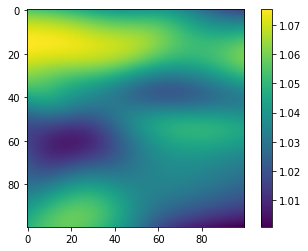

In [ ]:
uplot=np.reshape(u_pred,(100,100))
plt.imshow(uplot)
plt.colorbar()

# Plotting the actual velocity 

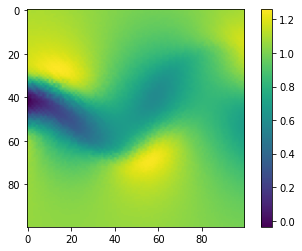

In [ ]:
upl=np.reshape(u_star,(100,100))
plt.imshow(upl)
plt.colorbar()